In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import os

In [6]:
window =  11

In [7]:
### calculate moving average
# define function for use of numpy arrays
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


### plotting routine
def plot_range(SampleData,ax1,col='steelblue',prctl=[5,25,50,75,95]):
 
 SDist=np.percentile(SampleData,prctl,axis=1).T

 x=np.arange(0,len(pd.DatetimeIndex(SampleData.time).year))
 #ax1.plot(x, SDist[:,2],)
 for i in range(int(np.floor(len(prctl)/2))+1):
     alph=0.15+(i/len(prctl))
     ax1.fill_between(x,SDist[:,0+i], SDist[:,len(prctl)-1-i], color=col, alpha=alph, edgecolor="none")
 return SDist

### plotting routine
def plot_bxp(SampleData,tim,j,ax1,col='steelblue',prctl=[5,25,50,75,95],linestyle='-',alpha=0.2,lbl=''):
    SDist=np.percentile(SampleData,prctl,axis=1).T
    for i in range(int(np.floor(len(prctl)/2))+1):
        ax1.vlines(tim,SDist[j,0+i], SDist[j,len(prctl)-1-i], color=col,linestyle=linestyle)
    
    ax1.plot(tim,SDist[j,int(np.floor(len(prctl)/2))], color=col, marker='o',label=lbl)

# Emission data

In [8]:
e_flat10=pd.read_csv('flat10.csv',header=4)
e_flat10_cdr=pd.read_csv('flat10_cdr.csv',header=4)
e_flat10_zec=pd.read_csv('flat10_zec.csv',header=4)
e_flat10_nz=pd.read_csv('flat10_cdr.csv',header=4)
e_flat10_nz[150:]=0


#Figure 2 (diagram)

# SCM data

In [9]:
# import fair, magicc, CSCM

# FaIR
ds_fair = xr.open_dataset('SCM_data/timeseries/flat10_FaIR.nc')

# MAGICC
ds_magicc = xr.open_dataset('SCM_data/timeseries/flat10_magicc.nc')

ds_magicc=ds_magicc.rename_vars(name_dict={'Atmospheric_Concentrations__CO2':'co2_concentration'})
ds_magicc=ds_magicc.rename_vars(name_dict={'Surface_Air_Temperature_Change':'temperature'})
ds_magicc=ds_magicc.rename_dims(dims_dict={'ensemble_member':'config'})

ds_magicc["scenario"]=("scenario",['esm-flat10','esm-flat10_cdr','esm-flat10_zec'])

# CSCM
ds_cicero = xr.open_dataset('SCM_data/timeseries/cic_flat10.nc')

ds_cicero=ds_cicero.rename_vars(name_dict={'concentrations-CO2':'co2_concentration'})
ds_cicero=ds_cicero.rename_vars(name_dict={'dT_glob':'temperature'})

#ds_cicero["scenario"]=("scenario",['esm-flat10','esm-flat10_zec','esm-flat10_cdr','esm-piControl'])

In [10]:
ds_cicero['temperature']=ds_cicero['temperature'].transpose("time", "scenario", "config")
ds_cicero['co2_concentration']=ds_cicero['co2_concentration'].transpose("time", "scenario", "config")   
ds_cicero['OHC700']=ds_cicero['OHC700'].transpose("time", "scenario", "config")
ds_cicero['RIB_glob'].transpose("time", "scenario", "config")
ds_cicero=ds_cicero.where(ds_cicero.time>=1850, drop=True)
ds_cicero['tcre']=ds_cicero['tcre'].isel({'time':0})
ds_cicero['zec50']=ds_cicero['zec50'].isel({'time':0})
ds_cicero['zec100']=ds_cicero['zec100'].isel({'time':0})


# Load ESM Data

In [11]:
# ESM data
def extd(ts,leng):
    out=np.zeros(leng)
    if leng>len(ts):
        out[:len(ts)]=ts.values
        out[len(ts):]=ts.iloc[-1]
    else:
        out=ts[:leng]
    return out
#mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS','NorESM2-LM','CNRM-ESM2-1','MPI-ESM1-2-LR']
mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM','UVic-ESCM-2-10','HadCM3LC-Bris']
expt=['esm-pictrl','1pctco2','flat10','flat10-zec','flat10-cdr']
flds=['tas','co2','fgco2','nbp','fCmissing']

ed={}
for m in mdls:
    ed[m]={}
    for e in expt:
        tmpa=[]
        for f in flds:
                print(f)
                fl10='ESM_data/'+m+'/'+'flat10'+'_'+f+'_'+m+'.nc'
                fl='ESM_data/'+m+'/'+e+'_'+f+'_'+m+'.nc'
                if os.path.exists(fl) and os.path.exists(fl10):
                    otmp=xr.open_dataset(fl)
                    otmp10=xr.open_dataset(fl10)
                    if 'nep' in list(otmp.keys()):
                        otmp=otmp.rename_vars({"nep": "nbp"})
                    if 'nep' in list(otmp10.keys()):
                        otmp10=otmp10.rename_vars({"nep": "nbp"})
                    if 'CO2_GLOB' in list(otmp10.keys()):
                        otmp10=otmp10.rename_vars({"CO2_GLOB": "co2"})
                        otmp=otmp.rename_vars({"CO2_GLOB": "co2"})
                    if 'NBP_GLOB' in list(otmp10.keys()):
                        otmp10=otmp10.rename_vars({"NBP_GLOB": "nbp"})
                        otmp=otmp.rename_vars({"NBP_GLOB": "nbp"})
                    if 'FGCO2_GLOB' in list(otmp10.keys()):
                        otmp10=otmp10.rename_vars({"FGCO2_GLOB": "fgco2"})
                        otmp=otmp.rename_vars({"FGCO2_GLOB": "fgco2"})    
                    if 'TIME' in list(otmp10.coords.keys()):                  
                        otmp10=otmp10.swap_dims({"TIME": "time"}).rename_vars({"TIME": "time"})
                    if 't' in list(otmp10.coords.keys()):                  
                        otmp10=otmp10.swap_dims({"t": "time"}).rename_vars({"t": "time"})
                    if 't' in list(otmp.coords.keys()):                  
                        otmp=otmp.swap_dims({"t": "time"}).rename_vars({"t": "time"})
                    if 'TIME' in list(otmp.coords.keys()):                  
                        otmp=otmp.swap_dims({"TIME": "time"}).rename_vars({"TIME": "time"})
                    if 'TAS_GLOB' in list(otmp10.keys()):                  
                        otmp10=otmp10.rename_vars({"TAS_GLOB": "tas"})
                    if 'TAS_GLOB' in list(otmp.keys()):                  
                        otmp=otmp.rename_vars({"TAS_GLOB": "tas"})
                        
                    if 'temp_mm_1_5m' in list(otmp10.keys()):                  
                        otmp10=otmp10.rename_vars({"temp_mm_1_5m": "tas"})
                    if 'temp_mm_1_5m' in list(otmp.keys()):                  
                        otmp=otmp.rename_vars({"temp_mm_1_5m": "tas"})
                    
                    if 'field1564_mm_hyb' in list(otmp10.keys()):
                        otmp10=otmp10.rename_vars({"field1564_mm_hyb": "co2"})
                        otmp=otmp.rename_vars({"field1564_mm_hyb": "co2"})
                    if 'unknown' in list(otmp10.keys()):
                        otmp10=otmp10.rename_vars({"unknown": "nbp"})
                        otmp=otmp.rename_vars({"unknown": "nbp"})
                   
                    if 'field1560_mm_srf' in list(otmp10.keys()):
                        otmp10=otmp10.rename_vars({"field1560_mm_srf": "fgco2"})
                        otmp=otmp.rename_vars({"field1560_mm_srf": "fgco2"})
                    if 'FCMISSING' in list(otmp.keys()):                  
                        otmp=otmp.rename_vars({"FCMISSING": "fCmissing"})    
                    if 'FCMISSING' in list(otmp10.keys()):                  
                        otmp10=otmp10.rename_vars({"FCMISSING": "fCmissing"})      
                    if '__xarray_dataarray_variable__' in list(otmp10.keys()):                  
                        otmp10=otmp10.rename_vars({"__xarray_dataarray_variable__": f})
                    if '__xarray_dataarray_variable__' in list(otmp.keys()):                  
                        otmp=otmp.rename_vars({"__xarray_dataarray_variable__": f})

                    tmp=otmp.copy(deep=True)
                    tmp10=otmp10.copy(deep=True)
                    
                    if e=='flat10':
                        if len(tmp.time)<1000:
                            tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
                        else:
                            tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
                        tmp=tmp[f]    
                    else: 
                        if len(tmp.time)<1000:
                            tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
                            tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
                        else:
                            tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
                            tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
  
                        tmp=xr.concat((tmp10.where(tmp10['time.year'] < 1800, drop=True)[f],tmp[f]),'time')
                    tmp=tmp.groupby('time.year').mean()
                    if len(tmp.shape)==2:
                        tmp=tmp.sel(lat=0).sel(lon=0).drop('lev')
                    if len(tmp.shape)==3:
                        tmp=tmp.sel(lat=0).sel(lon=0).drop('lat').drop('lon')
                    if len(tmp.shape)==4:
                        if 'lev' in list(otmp10.coords.keys()):
                            tmp=tmp.sel(lat=0).sel(lon=0).isel(lev=[0]).drop('lat').drop('lon').drop('lev')
                        else:
                            tmp=tmp.sel(lat=0).sel(lon=0).isel(plev=[0]).drop('lat').drop('lon').drop('plev')
                    
                    if tmp.name=='tas':            
                        t10=tmp[0:20].mean().values
                        d10=tmp[20:40].mean().values-t10
                        t0=t10-d10/2
                        tmp=tmp-t0
                    tmpa.append(tmp)
                    if f=='fgco2' and m=='NorESM2-LM' and e=='flat10':
                     0
                else:
                    print(m+e+f)
                
             
        ed[m][e]=xr.merge(tmpa)
        if len(tmpa)>0:
            ed[m][e]['fco2fos']=ed[m][e]['tas'].copy()
            if e=='flat10':
                    ed[m][e]['fco2fos'].values=extd(e_flat10['Emission Rate (PgC a-1)'],len(ed[m][e]['year']))
            if e=='flat10-cdr':
                    ed[m][e]['fco2fos'].values=extd(e_flat10_cdr['Emission Rate (PgC a-1)'],len(ed[m][e]['year']))
            if e=='flat10-zec':
                    ed[m][e]['fco2fos'].values=extd(e_flat10_zec['Emission Rate (PgC a-1)'],len(ed[m][e]['year']))
            if m=='ACCESS-ESM1-5':
                ed[m][e]['co2']=ed[m][e]['co2']*1e6

            if m=='GFDL-ESM4':
                ed[m][e]['co2']=ed[m][e]['co2'].isel(lev=0)*1e6
                ed[m][e]['nbp']=ed[m][e]['nbp']*5.1e14/1e12*3600*24*365
                aco2=np.diff(ed[m][e]['co2'][:],append=ed[m][e]['co2'][-1])*2.12
                ln=len(ed[m][e]['fco2fos'])
                ed[m][e]['fgco2']=ed[m][e]['fgco2'][:ln]
                

            if m=='CESM2':
                ed[m][e]['fgco2']=ed[m][e]['fgco2']/1e15
                ed[m][e]['nbp']=ed[m][e]['nbp']/1e15
                
                ed[m][e]['co2']=280+np.cumsum(ed[m][e]['fco2fos']-ed[m][e]['fgco2']-ed[m][e]['nbp'])/2.12
            
                ed[m][e]['co2']=280+np.cumsum(ed[m][e]['fco2fos']-ed[m][e]['fgco2']-ed[m][e]['nbp'])/2.12
            if m=='NorESM2-LM':
                ed[m][e]['co2']=ed[m][e]['co2']*1e6
                #ed[m][e]['nbp']=ed[m][e]['nbp']*5.1e14/1e12*3600*24*365
                aco2=np.diff(ed[m][e]['co2'][:],append=ed[m][e]['co2'][-1])*2.12
                #ed[m][e]['nbp']=ed[m][e]['fco2fos']-aco2-ed[m][e]['fgco2']
                #ed[m][e]['fgco2']=ed[m][e]['fgco2']*5.1e14/1e12*3600*24*365
            if m=='UKESM':
                ed[m][e]['nbp']=ed[m][e]['nbp']*5.1e14/1e12*.29
                #ed[m][e]['nbp']=ed[m][e]['nbp']*5.1e14/1e12*3600*24*365
                #ed[m][e]['fgco2']=ed[m][e]['fgco2']*5.1e14/1e12*3600*24*365*.71
            if m=='CNRM-ESM2-1':
                ed[m][e]['fgco2']=ed[m][e]['fgco2']-ed[m][e]['fCmissing']
                #ed[m][e]['nbp']=ed[m][e]['nbp']*5.1e14/1e12*3600*24*365
                #ed[m][e]['fgco2']=ed[m][e]['fgco2']*5.1e14/1e12*3600*24*365*.71
            if m=='HadCM3LC-Bris':
                0#ed[m][e]['fgco2']=ed[m][e]['fgco2']*5.1e14/1e12*.71
                ed[m][e]['nbp']=ed[m][e]['nbp']*.29
                


ed["GFDL-ESM4"]['flat10']['fgco2'][0] = ed["GFDL-ESM4"]['flat10']['fgco2'][0]-10        # correct first ocean value of GFDL-ESM4
ed["GFDL-ESM4"]['flat10-zec']['fgco2'][0] = ed["GFDL-ESM4"]['flat10-zec']['fgco2'][0]-10        # correct first ocean value of GFDL-ESM4
ed["GFDL-ESM4"]['flat10-cdr']['fgco2'][0] = ed["GFDL-ESM4"]['flat10-cdr']['fgco2'][0]-10        # correct first ocean value of GFDL-ESM4

for i,m in enumerate(mdls):
    print(m)
    try:
        ed[m]['flat10-cdr']['C_atm']=(ed[m]['flat10-cdr']['co2']-ed[m]['flat10']['co2'][0])*2.13
    except:
        print('fail cdr')
    try:
        ed[m]['flat10-zec']['C_atm']=(ed[m]['flat10-zec']['co2']-ed[m]['flat10']['co2'][0])*2.13
    except:
        print('fail zec')
    try:
        ed[m]['flat10']['C_atm']=(ed[m]['flat10']['co2']-ed[m]['flat10']['co2'][0])*2.13

    except:
        print('fail flat')    


t0mat={}
for i,m in enumerate(mdls):
    x = np.arange(0,50)
    y = np.array(ed[m]['flat10']['tas'][:50])
    t0mat[m]=y[1]
    ed[m]['flat10-cdr']['tas'] = ed[m]['flat10-cdr']['tas']-y[1]
    ed[m]['flat10-zec']['tas'] = ed[m]['flat10-zec']['tas']-y[1]
    ed[m]['flat10']['tas'] = ed[m]['flat10']['tas']-y[1]

tas
ACCESS-ESM1-5esm-pictrltas
co2
ACCESS-ESM1-5esm-pictrlco2
fgco2
ACCESS-ESM1-5esm-pictrlfgco2
nbp
ACCESS-ESM1-5esm-pictrlnbp
fCmissing
ACCESS-ESM1-5esm-pictrlfCmissing
tas
ACCESS-ESM1-51pctco2tas
co2
ACCESS-ESM1-51pctco2co2
fgco2
ACCESS-ESM1-51pctco2fgco2
nbp
ACCESS-ESM1-51pctco2nbp
fCmissing
ACCESS-ESM1-51pctco2fCmissing
tas
co2


/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cfti

fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:99: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tmp=tmp.sel(lat=0).sel(lon=0).drop('lat').drop('lon')
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationW

fCmissing
ACCESS-ESM1-5flat10fCmissing
tas
co2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:99: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tmp=tmp.sel(lat=0).sel(lon=0).drop('lat').drop('lon')
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationW

fgco2
nbp
fCmissing
ACCESS-ESM1-5flat10-zecfCmissing
tas


/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cfti

co2
fgco2
nbp


/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykerne

fCmissing
ACCESS-ESM1-5flat10-cdrfCmissing
tas
CESM2esm-pictrltas
co2
CESM2esm-pictrlco2
fgco2
CESM2esm-pictrlfgco2
nbp
CESM2esm-pictrlnbp
fCmissing
CESM2esm-pictrlfCmissing
tas
CESM21pctco2tas
co2
CESM21pctco2co2
fgco2
CESM21pctco2fgco2
nbp
CESM21pctco2nbp
fCmissing
CESM21pctco2fCmissing
tas
co2
CESM2flat10co2
fgco2
nbp
fCmissing
CESM2flat10fCmissing
tas


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use '

co2
CESM2flat10-zecco2
fgco2
nbp
fCmissing
CESM2flat10-zecfCmissing
tas
co2
CESM2flat10-cdrco2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please u

fCmissing
CESM2flat10-cdrfCmissing
tas
GFDL-ESM4esm-pictrltas
co2
GFDL-ESM4esm-pictrlco2
fgco2
GFDL-ESM4esm-pictrlfgco2
nbp
GFDL-ESM4esm-pictrlnbp
fCmissing
GFDL-ESM4esm-pictrlfCmissing
tas
GFDL-ESM41pctco2tas
co2
GFDL-ESM41pctco2co2
fgco2
GFDL-ESM41pctco2fgco2
nbp
GFDL-ESM41pctco2nbp
fCmissing
GFDL-ESM41pctco2fCmissing
tas
co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:99: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tmp=tmp.sel(lat=0).sel(lon=0).drop('lat').drop('lon')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:102: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tmp=tmp.sel(lat=0).sel(lon=0).isel(lev=[0]).drop('lat').drop('lon').drop('lev')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.

fCmissing
GFDL-ESM4flat10fCmissing
tas
co2
fgco2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:99: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tmp=tmp.sel(lat=0).sel(lon=0).drop('lat').drop('lon')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-

nbp
fCmissing
GFDL-ESM4flat10-zecfCmissing
tas
co2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:99: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tmp=tmp.sel(lat=0).sel(lon=0).drop('lat').drop('lon')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-

fgco2
nbp
fCmissing
GFDL-ESM4flat10-cdrfCmissing
tas
co2
fgco2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please u

nbp
fCmissing
GISSesm-pictrlfCmissing
tas
co2
fgco2
nbp
fCmissing
GISS1pctco2fCmissing
tas
co2
fgco2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use '

nbp
fCmissing
GISSflat10fCmissing
tas
co2
fgco2
nbp
fCmissing
GISSflat10-zecfCmissing
tas
co2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please u

fgco2
nbp
fCmissing
GISSflat10-cdrfCmissing
tas
co2
fgco2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

nbp
fCmissing
NorESM2-LMesm-pictrlfCmissing
tas
NorESM2-LM1pctco2tas
co2
NorESM2-LM1pctco2co2
fgco2
NorESM2-LM1pctco2fgco2
nbp
NorESM2-LM1pctco2nbp
fCmissing
NorESM2-LM1pctco2fCmissing
tas
co2
fgco2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use '

nbp
fCmissing
NorESM2-LMflat10fCmissing
tas
co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

fCmissing
NorESM2-LMflat10-zecfCmissing
tas
co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

fCmissing
NorESM2-LMflat10-cdrfCmissing
tas
MPI-ESM1-2-LResm-pictrltas
co2
MPI-ESM1-2-LResm-pictrlco2
fgco2
MPI-ESM1-2-LResm-pictrlfgco2
nbp
MPI-ESM1-2-LResm-pictrlnbp
fCmissing
MPI-ESM1-2-LResm-pictrlfCmissing
tas
MPI-ESM1-2-LR1pctco2tas
co2
MPI-ESM1-2-LR1pctco2co2
fgco2
MPI-ESM1-2-LR1pctco2fgco2
nbp
MPI-ESM1-2-LR1pctco2nbp
fCmissing
MPI-ESM1-2-LR1pctco2fCmissing
tas
co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:104: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  tmp=tmp.sel(lat=0).sel(lon=0).isel(plev=[0]).drop('lat').drop('lon').drop('plev')
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-pac

fCmissing
MPI-ESM1-2-LRflat10fCmissing
tas
co2
fgco2
nbp
fCmissing
MPI-ESM1-2-LRflat10-zecfCmissing
tas


/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dty

co2
fgco2
nbp
fCmissing
MPI-ESM1-2-LRflat10-cdrfCmissing
tas
CNRM-ESM2-1esm-pictrltas
co2
CNRM-ESM2-1esm-pictrlco2
fgco2
CNRM-ESM2-1esm-pictrlfgco2
nbp
CNRM-ESM2-1esm-pictrlnbp
fCmissing
CNRM-ESM2-1esm-pictrlfCmissing
tas
CNRM-ESM2-11pctco2tas
co2
CNRM-ESM2-11pctco2co2
fgco2
CNRM-ESM2-11pctco2fgco2
nbp
CNRM-ESM2-11pctco2nbp
fCmissing
CNRM-ESM2-11pctco2fCmissing
tas


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/Users/bensan/Documents/Github/esm-deck/.venv/lib/python3.12/site-packages/xarray/core/indexing.py:654: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:99: DeprecationWarning: dropping variables using `drop` is deprecat

co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')


fCmissing
tas
co2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

fCmissing
tas


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

co2
fgco2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

nbp
fCmissing


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

tas
UKESMesm-pictrltas
co2
UKESMesm-pictrlco2
fgco2
UKESMesm-pictrlfgco2
nbp
UKESMesm-pictrlnbp
fCmissing
UKESMesm-pictrlfCmissing
tas
UKESM1pctco2tas
co2
UKESM1pctco2co2
fgco2
UKESM1pctco2fgco2
nbp
UKESM1pctco2nbp
fCmissing
UKESM1pctco2fCmissing
tas
co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' 

fCmissing
UKESMflat10fCmissing
tas
co2
fgco2
nbp
fCmissing
UKESMflat10-zecfCmissing
tas
co2
fgco2
nbp
fCmissing


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please u

UKESMflat10-cdrfCmissing
tas
UVic-ESCM-2-10esm-pictrltas
co2
UVic-ESCM-2-10esm-pictrlco2
fgco2
UVic-ESCM-2-10esm-pictrlfgco2
nbp
UVic-ESCM-2-10esm-pictrlnbp
fCmissing
UVic-ESCM-2-10esm-pictrlfCmissing
tas
UVic-ESCM-2-101pctco2tas
co2
UVic-ESCM-2-101pctco2co2
fgco2
UVic-ESCM-2-101pctco2fgco2
nbp
UVic-ESCM-2-101pctco2nbp
fCmissing
UVic-ESCM-2-101pctco2fCmissing
tas
co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:82: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' 

fCmissing
UVic-ESCM-2-10flat10fCmissing
tas
co2
fgco2
nbp
fCmissing
UVic-ESCM-2-10flat10-zecfCmissing
tas


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please u

co2
fgco2
nbp
fCmissing
UVic-ESCM-2-10flat10-cdrfCmissing
tas


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='Y')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:89: FutureWarning: 'Y' is deprecated and will be removed in a future version, please u

co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use '

fCmissing
HadCM3LC-Brisesm-pictrlfCmissing
tas
HadCM3LC-Bris1pctco2tas
co2
HadCM3LC-Bris1pctco2co2
fgco2
HadCM3LC-Bris1pctco2fgco2
nbp
HadCM3LC-Bris1pctco2nbp
fCmissing
HadCM3LC-Bris1pctco2fCmissing
tas
co2
fgco2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')


nbp
fCmissing
HadCM3LC-Brisflat10fCmissing
tas
co2


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1700-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use '

fgco2
nbp
fCmissing
HadCM3LC-Brisflat10-zecfCmissing
tas


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

co2
fgco2
nbp


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp.coords['time']=pd.date_range('1800-01-01', periods=tmp['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tmp10.coords['time']=pd.date_range('1700-01-01', periods=tmp10['time'].values.shape[0],freq='M')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2116011301.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please u

fCmissing
HadCM3LC-Brisflat10-cdrfCmissing
ACCESS-ESM1-5
CESM2
GFDL-ESM4
GISS
NorESM2-LM
MPI-ESM1-2-LR
CNRM-ESM2-1
UKESM
UVic-ESCM-2-10
HadCM3LC-Bris


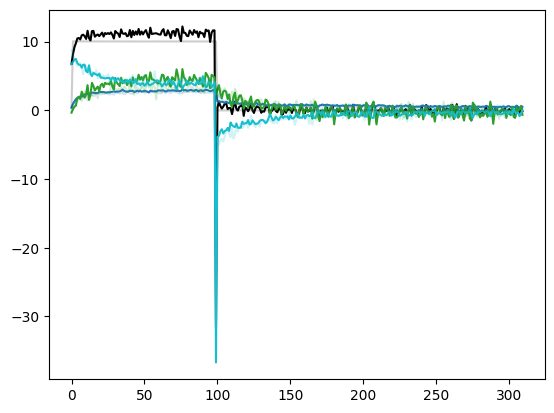

In [12]:
m='NorESM2-LM'
e='flat10-zec'
plt.plot(ed[m][e]['nbp']+ed[m][e]['fgco2']+np.diff(ed[m][e]['C_atm'],append=ed[m][e]['C_atm'][-1]),color='k')
plt.plot(ed[m][e]['fgco2'],color='tab:blue')
plt.plot(ed[m][e]['nbp'],color='tab:green')
plt.plot(np.diff(ed[m][e]['C_atm'],append=ed[m][e]['C_atm'][-1]),color='tab:cyan')
plt.grid()
m='CESM2'

plt.plot(ed[m][e]['nbp']+ed[m][e]['fgco2']+np.diff(ed[m][e]['C_atm'],prepend=ed[m][e]['C_atm'][0]),color='k',alpha=.2)
plt.plot(ed[m][e]['fgco2'],color='tab:blue',alpha=.2)
plt.plot(ed[m][e]['nbp'],color='tab:green',alpha=.2)
plt.plot(np.diff(ed[m][e]['C_atm'],append=ed[m][e]['C_atm'][-1]),color='tab:cyan',alpha=.2)
plt.grid()

In [13]:
colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]


Figure 4 (ESM/SCM)

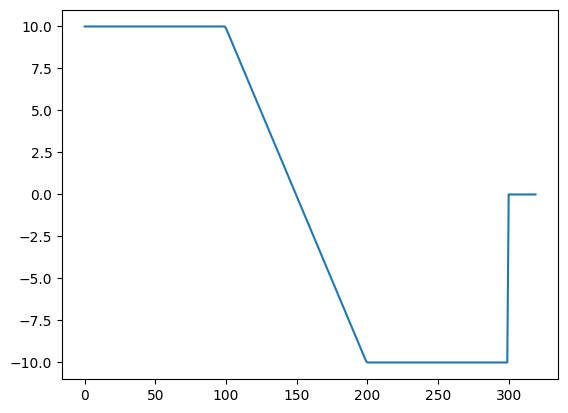

In [14]:
plt.plot(e_flat10_cdr['Emission Rate (PgC a-1)'])

In [15]:
signal=e_flat10_cdr['Emission Rate (PgC a-1)']

In [16]:
def f_exp(x, a, tau):
    return a*(1-np.exp(-x/tau) )  

In [17]:
def convolve_signal_with_exp(signal, a, tau):
    # Define the exponential pulse-response function
    pulse_response=[]
    convolved_signal = np.zeros((len(signal),len(tau)))
    for i,am in enumerate(a):
       
        tau[i]
        # Create the exponential pulse-response function values
        pulse_response = f_exp(np.arange(len(signal)), a[i], tau[i])
    
        # Convolve the signal with the pulse-response function
        convolved_signal[:,i] = np.convolve(pulse_response, signal, mode='full')[:len(signal)]
        
    out=sum(convolved_signal.T)
    return out

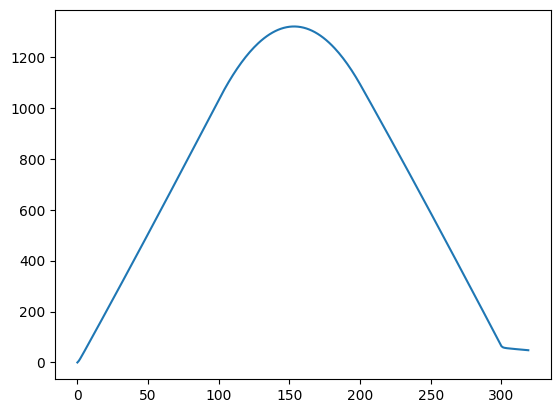

In [18]:
plt.plot(convolve_signal_with_exp(signal, [1,.1], [1,100]))

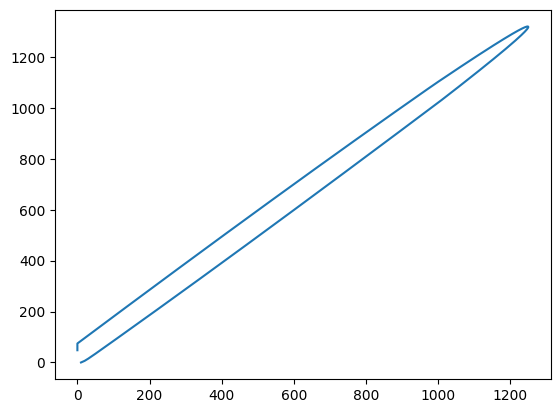

In [19]:
plt.plot(np.cumsum(signal),convolve_signal_with_exp(signal, [1,.1], [1,100]))

In [59]:
from scipy.optimize import minimize

def objective(params, signals, targets):
    a = params[:3]
    tau = params[3:]
    scr=0
    for i,signal in enumerate(signals):
        target=targets[i]

        convolved_signal = convolve_signal_with_exp(signal, a, tau)
        scr=scr+np.sum((convolved_signal[:len(target)] - target)**2)

    return scr

In [67]:
mdls

['ACCESS-ESM1-5',
 'CESM2',
 'GFDL-ESM4',
 'GISS',
 'NorESM2-LM',
 'MPI-ESM1-2-LR',
 'CNRM-ESM2-1',
 'UKESM',
 'UVic-ESCM-2-10',
 'HadCM3LC-Bris']

In [81]:
mdl='GFDL-ESM4'

signal_zec=e_flat10_zec['Emission Rate (PgC a-1)']
signal_cdr=e_flat10_cdr['Emission Rate (PgC a-1)']
signal=e_flat10['Emission Rate (PgC a-1)']


target_zec=ed[mdl]['flat10-zec']['tas']
target_cdr=ed[mdl]['flat10-cdr']['tas']
target=ed[mdl]['flat10']['tas']

In [83]:


# Initial guess for a and tau
bnds = ((-.1, .1), (-.1, .1),(-.1,.1),(1, 10), (10, 100), (10, 1000))
initial_guess = [0.0025, -0.002,0.001, 5, 30,500]

# Optimize for signal_zec and target_zec
result_zec = minimize(objective, initial_guess, args=([signal,signal_zec,signal_cdr], [target,target_zec,target_cdr]))
optimized_a_zec = result_zec.x[:3]
optimized_tau_zec = result_zec.x[3:]


print("Optimized parameters for ZEC:")
print("a:", optimized_a_zec)
print("tau:", optimized_tau_zec)


ValueError: operands could not be broadcast together with shapes (150,) (200,) 

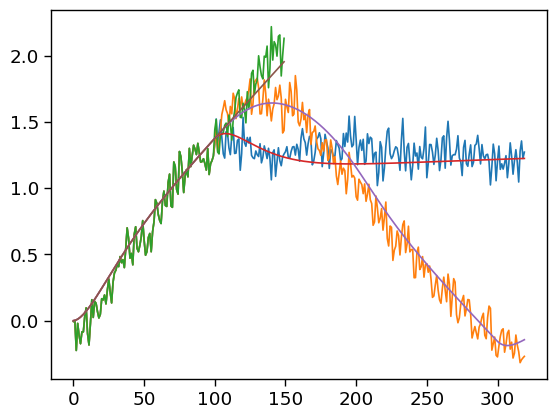

In [78]:
plt.plot(ed[mdl]['flat10-zec']['tas'])
plt.plot(ed[mdl]['flat10-cdr']['tas'])
plt.plot(ed[mdl]['flat10']['tas'])
plt.plot(convolve_signal_with_exp(e_flat10_zec['Emission Rate (PgC a-1)'], optimized_a_zec, optimized_tau_zec))
plt.plot(convolve_signal_with_exp(e_flat10_cdr['Emission Rate (PgC a-1)'], optimized_a_zec, optimized_tau_zec))
plt.plot(convolve_signal_with_exp(e_flat10['Emission Rate (PgC a-1)'], optimized_a_zec, optimized_tau_zec))

<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:91: SyntaxWarning: invalid escape sequence '\D'
<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:91: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/193572547.py:47: SyntaxWarning: invalid escape sequence '\D'
  axs[0].set_ylabel('$\Delta$ GMST [K]')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/193572547.py:91: SyntaxWarning: invalid escape sequence '\D'
  axs[1].set_ylabel('$\Delta$ GMST - $T_{1000PgC}$ [K]')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/193572547.py:47: SyntaxWarning: invalid escape sequence '\D'
  axs[0].set_ylabel('$\Delta$ GMST [K]')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/193572547.py:91: SyntaxWarning: invalid escape sequence '\D'
  axs[1].set_ylabel('$\Delta$ GMST - $T_{1000PgC}$ [K]')


KeyError: 0

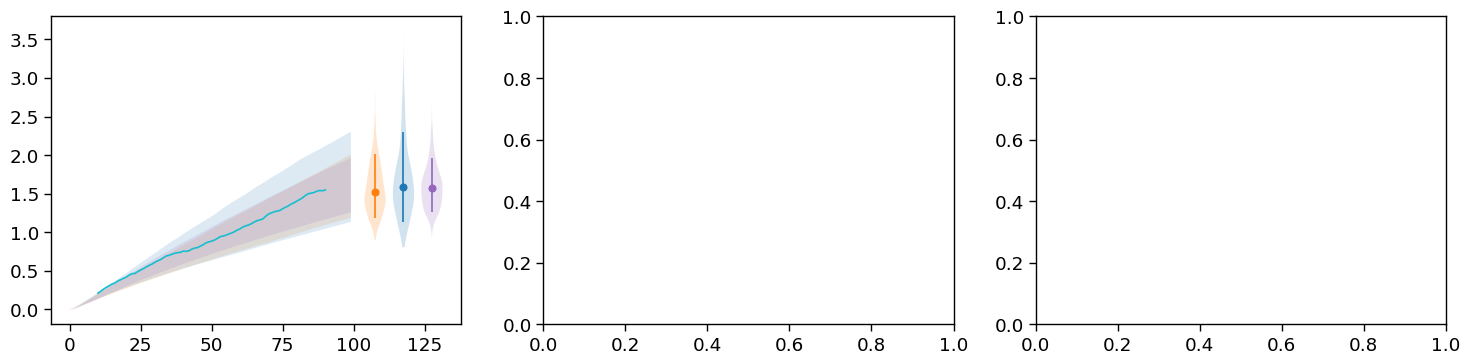

In [57]:
# combined SCM and ESM results
mcols=colors
#mcols=["tab:blue","tab:orange","tab:green","tab:red","tab:gray","tab:purple","tab:cyan","tab:brown"]
t_100=ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
t_100pl=ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))
t_100plc=ds_fair.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,200))

m_100=ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=100).T
m_100pl=ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300)).T
m_100plc=ds_magicc.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,200)).T

c_100=ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
c_100pl=ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))
c_100plc=ds_cicero.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,200))

fig, axs = plt.subplots(1, 3,figsize=[18,4])
axs=axs.flatten()

# subfigure 1
plot_range(ds_fair.temperature.sel(scenario='esm-flat10').isel(time=slice(0,100)),axs[0],prctl=[10,50,90],col='tab:orange')
pv = axs[0].violinplot(ds_fair.temperature.sel(scenario='esm-flat10').isel(time=slice(0,100))[-1], [107.5], widths=7.5, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('tab:orange'), pc.set_alpha(0.2)
plot_bxp(ds_fair.temperature.sel(scenario='esm-flat10').isel(time=slice(0,100)),107.5,99,axs[0],prctl=[10,50,90],col='tab:orange',linestyle='-')

plot_range(ds_magicc.temperature.sel(scenario='esm-flat10').isel(time=slice(0,100)).T,axs[0],prctl=[10,50,90],col="tab:blue")
pv = axs[0].violinplot(ds_magicc.temperature.sel(scenario='esm-flat10').isel(time=slice(0,100)).T[-1], [117.5], widths=7.5, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('tab:blue'), pc.set_alpha(0.2)
plot_bxp(ds_magicc.temperature.sel(scenario='esm-flat10').isel(time=slice(00,100)).T,117.5,99,axs[0],prctl=[10,50,90],col='tab:blue',linestyle='-')

plot_range(ds_cicero.temperature.sel(scenario='esm-flat10').isel(time=slice(0,100)),axs[0],prctl=[10,50,90],col='tab:purple')
pv = axs[0].violinplot(ds_cicero.temperature.sel(scenario='esm-flat10').isel(time=slice(0,100))[-1], [127.5], widths=7.5, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('tab:purple'), pc.set_alpha(0.2)
plot_bxp(ds_cicero.temperature.sel(scenario='esm-flat10').isel(time=slice(00,100)),127.5,99,axs[0],prctl=[10,50,90],col='tab:purple',linestyle='-')

pl=[]
for i,m in enumerate(mdls):

    cn0=ed[m]['flat10']['tas'][:20].mean()-(ed[m]['flat10']['tas'][10:30:1].mean()-ed[m]['flat10']['tas'][:20].mean())
    tmp==axs[0].plot(ed[m]['flat10']['tas'][:100].rolling(year=20,center=True).mean()-cn0,color=mcols[i],label=m)
    pl.append(tmp[0])
    print(m)

    axs[0].set_ylim([-0.5,2.5])
axs[0].set_xticks([0,20,40,60,80,100])
axs[0].set_xticklabels([0,20,40,60,80,100])
axs[0].set_title('flat10')
axs[0].set_ylabel('$\Delta$ GMST [K]')
axs[0].set_ylabel('years')
axs[0].axhline(0, color="black", lw=0.5, linestyle="--", zorder=0)
axs[0].axvline(100, color="black", lw=0.8)
axs[0].legend(frameon=False, ncol=3, bbox_to_anchor=(1.9, -0.1))
axs[0].annotate('a)', xy=(0.03, 0.94), xycoords='axes fraction', fontsize=14, ha='left', va='center')
axs[0].plot([0,100],[0,1],':',color='grey')
axs[0].plot([0,100],[0,2],':',color='grey')
axs[0].plot([0,100],[0,3],':',color='grey')
axs[0].text(60,.46,'TCRE=1K/EgC',rotation=21,color='grey')
axs[0].text(30,1.02,'TCRE=3K/EgC',rotation=48,color='grey')
axs[0].text(60,1.3,'TCRE=2K/EgC',rotation=36,color='grey')




# subfigure 2
plot_range(ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))-t_100,axs[1],prctl=[10,50,90],col='tab:orange')
pv = axs[1].violinplot((ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))-t_100)[-1], [215], widths=15, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('tab:orange'), pc.set_alpha(0.2)
plot_bxp(ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))-t_100,215,199,axs[1],prctl=[10,50,90],col='tab:orange',linestyle='-',lbl='FaIR')

plot_range(ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300)).T-m_100,axs[1],prctl=[10,50,90])
pv = axs[1].violinplot((ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300)).T-m_100)[-1], [235], widths=15, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('tab:blue'), pc.set_alpha(0.2)
plot_bxp(ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300)).T-m_100,235,199,axs[1],prctl=[10,50,90],col='tab:blue',linestyle='-',lbl='MAGICC')

plot_range(ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))-c_100,axs[1],prctl=[10,50,90],col='tab:purple')
pv = axs[1].violinplot((ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))-c_100)[-1], [255], widths=15, quantiles=[0.5], showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('purple'), pc.set_alpha(0.2)
plot_bxp(ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=slice(100,300))-c_100,255,199,axs[1],prctl=[10,50,90],col='tab:purple',linestyle='-',lbl='CICERO-SCM')

pl=[]
for i,m in enumerate(mdls):
    try:
     lnzec=np.min([len(ed[m]['flat10-zec']['tas'][1:][:]),300])
     tmp==axs[1].plot(ed[m]['flat10-zec']['tas'][89:lnzec].rolling(year=20,center=True).mean()-ed[m]['flat10']['tas'][90:110].mean(),color=mcols[i])
     pl.append(tmp[0])
    except:
        0
axs[1].set_ylim([-0.75,0.75])
axs[1].set_xticks([0,50,100,150,200])
axs[1].set_xticklabels([100,150,200,350,300])
axs[1].set_title('flat10-zec')
axs[1].set_ylabel('$\Delta$ GMST - $T_{1000PgC}$ [K]')
axs[1].axhline(0, color="black", lw=0.5, linestyle="--", zorder=0)
axs[1].axvline(200, color="black", lw=0.8)
axs[1].legend(frameon=False, ncol=2, bbox_to_anchor=(2., -0.1))
axs[1].annotate('b)', xy=(0.03, 0.94), xycoords='axes fraction', fontsize=14, ha='left', va='center')

# subfigure 3
plot_range(ds_fair.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300))-t_100,axs[2],prctl=[10,50,90],col='tab:orange')
pv = axs[2].violinplot((ds_fair.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300))-t_100)[-1], [215], widths=15, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('tab:orange'), pc.set_alpha(0.2)
plot_bxp(ds_fair.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300))-t_100,215,199,axs[2],prctl=[10,50,90],col='tab:orange',linestyle='-',lbl='FaIR')

plot_range(ds_magicc.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300)).T-m_100,axs[2],prctl=[10,50,90], col="tab:blue")
pv = axs[2].violinplot((ds_magicc.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300)).T-m_100)[-1], [235], widths=15, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('tab:blue'), pc.set_alpha(0.2)
plot_bxp(ds_magicc.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300)).T-m_100,235,199,axs[2],prctl=[10,50,90],col='tab:blue',linestyle='-',lbl='MAGICC')

plot_range(ds_cicero.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300))-c_100,axs[2],prctl=[10,50,90],col='tab:purple')
pv = axs[2].violinplot((ds_cicero.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300))-c_100)[-1], [255], widths=15, showmeans=False, showextrema=False, showmedians=False)
for pc in pv['bodies']: pc.set_facecolor('purple'), pc.set_alpha(0.2)
plot_bxp(ds_cicero.temperature.sel(scenario='esm-flat10_cdr').isel(time=slice(100,300))-c_100,255,199,axs[2],prctl=[10,50,90],col='tab:purple',linestyle='-',lbl='CICERO')

pl=[]
for i,m in enumerate(mdls):
    try:
     lncdr=np.min([len(ed[m]['flat10-cdr']['tas'][1:][:]),300])
     tmp==axs[2].plot(ed[m]['flat10-cdr']['tas'][89:lncdr].rolling(year=20,center=True).mean()-ed[m]['flat10']['tas'][90:110].mean(),color=mcols[i],label=m)
     pl.append(tmp[0])
    except:
        0
    axs[2].set_ylim([-3.5,1])
axs[2].set_xticks([0,50,100,150,200])
axs[2].set_xticklabels([100,150,200,250,300])
axs[2].set_title('flat10-cdr')
axs[2].set_ylabel(r'$\Delta$ GMST - $T_{100yr}$ [K]')
axs[2].axhline(0, color="black", lw=0.5, linestyle="--", zorder=0)
axs[2].axvline(200, color="black", lw=0.8)
axs[2].annotate('c)', xy=(0.03, 0.94), xycoords='axes fraction', fontsize=14, ha='left', va='center')

fig.subplots_adjust(wspace=0.22, hspace=0.2)
#plt.tight_layout()
    
plt.savefig("images/flat10_SCM_ESM_results_panel.pdf", bbox_inches='tight')
plt.savefig("images/flat10_SCM_ESM_results_panel.jpg", bbox_inches='tight')

Figure 5 (ESM)

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:76: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:76: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/154752283.py:10: SyntaxWarning: invalid escape sequence '\D'
  axes[0].set_ylabel("$\Delta$ GMST [K]")
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/154752283.py:76: SyntaxWarning: invalid escape sequence '\D'
  axes[3].set_ylabel("$\Delta$ Atmospheric CO$_2$ [ppm]")


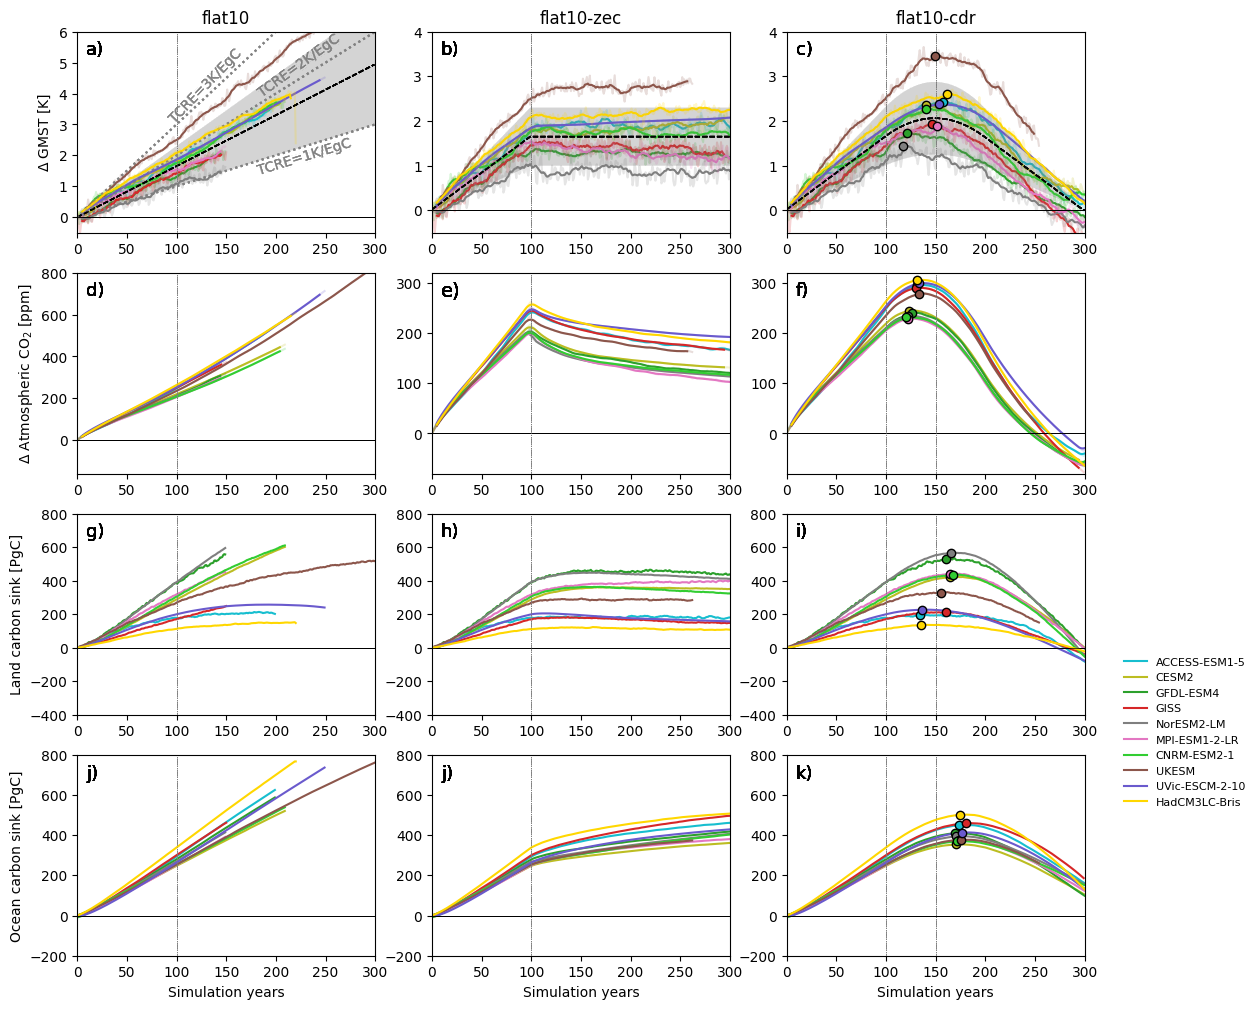

In [24]:

fig, axes = plt.subplots(4,3,figsize=(13, 12))
axes=axes.flatten()

### Temperature
for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10']['tas'])-int(window/2))

    axes[0].set_title("flat10")
    axes[0].set_ylabel("$\Delta$ GMST [K]")
    axes[0].set_ylim([-0.5,6])
    axes[0].set_xlim([0,300])
    axes[0].plot(ed[mdls[i]]['flat10']['tas'],alpha=0.2,color=colors[i])
    axes[0].plot(time_ma,moving_average(ed[mdls[i]]['flat10']['tas'],window),color=colors[i],label=mdls[i])

    axes[0].plot(np.arange(0,300)*10*1.65/1000, color='black', lw=1, linestyle="--")
    axes[0].fill_between(np.arange(0,320), np.arange(0,320)*10*1.0/1000, np.arange(0,320)*10*2.3/1000, color="gray", alpha=0.035, edgecolor="none")
    axes[0].plot([0,300],[0,3],':',color='grey',alpha=0.3)
    axes[0].plot([0,300],[0,6],':',color='grey',alpha=0.3)
    axes[0].plot([0,300],[0,9],':',color='grey',alpha=0.3)
    axes[0].text(60*3,.46*3,'TCRE=1K/EgC',rotation=17,color='grey',alpha=0.3)
    axes[0].text(30*3,1.02*3,'TCRE=3K/EgC',rotation=46,color='grey',alpha=0.3)
    axes[0].text(60*3,1.3*3,'TCRE=2K/EgC',rotation=36,color='grey',alpha=0.3)


    axes[0].axhline(0,lw=0.5,color="black")
    axes[0].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[0].annotate('a)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-zec']['tas'])-int(window/2))

    axes[1].set_title("flat10-zec")
    axes[1].set_ylim([-0.5,4])
    axes[1].set_xlim([0,300])
    axes[1].plot(ed[mdls[i]]['flat10-zec']['tas'],alpha=0.2,color=colors[i])
    axes[1].plot(time_ma,moving_average(ed[mdls[i]]['flat10-zec']['tas'],window),color=colors[i])

    axes[1].plot(np.cumsum(np.array(e_flat10_zec)[:,1])*1.65/1000, lw=1, color='black', linestyle="--")
    axes[1].fill_between(np.arange(0,320), np.cumsum(np.array(e_flat10_zec)[:,1])*1.0/1000, np.cumsum(np.array(e_flat10_zec)[:,1])*2.3/1000, lw=2, color="gray", alpha=0.035, edgecolor="none", zorder=2)

    axes[1].axhline(0,lw=0.5,color="black")
    axes[1].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[1].annotate('b)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-cdr']['tas'])-int(window/2))

    axes[2].set_title("flat10-cdr")
    axes[2].set_ylim([-0.5,4])
    axes[2].set_xlim([0,300])
    axes[2].plot(ed[mdls[i]]['flat10-cdr']['tas'],alpha=0.2,color=colors[i])
    axes[2].plot(time_ma,moving_average(ed[mdls[i]]['flat10-cdr']['tas'],window),color=colors[i])

    axes[2].plot(np.cumsum(np.array(e_flat10_cdr)[:,1])*1.65/1000, lw=1, color='black', linestyle="--")
    axes[2].fill_between(np.arange(0,320), np.cumsum(np.array(e_flat10_cdr)[:,1])*1.0/1000, np.cumsum(np.array(e_flat10_cdr)[:,1])*2.3/1000, lw=2, color="gray", alpha=0.035, edgecolor="none", zorder=2)

    # indicate max value
    mxy=np.max(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['tas']),window))
    mxyidx = np.where(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['tas']),window)==mxy)[0]
    axes[2].scatter(mxyidx,mxy,color=colors[i], edgecolor="black", zorder=4)

    axes[2].axhline(0,lw=0.5,color="black")
    axes[2].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[2].axvline(150,lw=0.5,color="gray",linestyle=":")
    axes[2].annotate('c)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

### Atmospheric CO2
for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10']['co2'])-int(window/2))

    #axes[3].set_title("flat10")
    axes[3].set_ylabel("$\Delta$ Atmospheric CO$_2$ [ppm]")
    axes[3].set_ylim([-160,800])
    axes[3].set_xlim([0,300])
    axes[3].plot(ed[mdls[i]]['flat10']['co2']-ed[mdls[i]]['flat10']['co2'][0],alpha=0.2,color=colors[i])
    axes[3].plot(time_ma,moving_average(np.squeeze(ed[mdls[i]]['flat10']['co2']-ed[mdls[i]]['flat10']['co2'][0]),window),color=colors[i],label=mdls[i])

    axes[3].axhline(0,lw=0.5,color="black")
    axes[3].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[3].annotate('d)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-zec']['co2'])-int(window/2))

    #axes[4].set_title("flat10-zec")
    axes[4].set_ylim([-80,320])
    axes[4].set_xlim([0,300])
    axes[4].plot(ed[mdls[i]]['flat10-zec']['co2']-ed[mdls[i]]['flat10-zec']['co2'][0],alpha=0.2,color=colors[i])
    axes[4].plot(time_ma,moving_average(np.squeeze(ed[mdls[i]]['flat10-zec']['co2']-ed[mdls[i]]['flat10-zec']['co2'][0]),window),color=colors[i])

    axes[4].axhline(0,lw=0.5,color="black")
    axes[4].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[4].annotate('e)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=14, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-cdr']['co2'])-int(window/2))

    #axes[5].set_title("flat10-cdr")
    axes[5].set_ylim([-80,320])
    axes[5].set_xlim([0,300])
    axes[5].plot(ed[mdls[i]]['flat10-cdr']['co2']-ed[mdls[i]]['flat10-cdr']['co2'][0],alpha=0.2,color=colors[i])
    axes[5].plot(time_ma,moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['co2']-ed[mdls[i]]['flat10-cdr']['co2'][0]),window),color=colors[i])

    # indicate max value
    mxy=np.max(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['co2']-ed[mdls[i]]['flat10-cdr']['co2'][0]),window))
    mxyidx = np.where(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['co2']-ed[mdls[i]]['flat10-cdr']['co2'][0]),window)==mxy)[0]
    axes[5].scatter(mxyidx,mxy,color=colors[i], edgecolor="black", zorder=4)

    axes[5].axhline(0,lw=0.5,color="black")
    axes[5].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[5].axvline(150,lw=0.5,color="gray",linestyle=":")
    axes[5].annotate('f)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

### Land carbon
for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10']['nbp'])-int(window/2))

    #axes[6].set_title("flat10")
    axes[6].set_ylabel("Land carbon sink [PgC]")
    axes[6].set_ylim([-400,800])
    axes[6].set_xlim([0,300])
    axes[6].plot(np.cumsum(ed[mdls[i]]['flat10']['nbp'].values),color=colors[i],label=mdls[i])
    axes[6].axhline(0,lw=0.5,color="black")
    axes[6].axvline(100,lw=0.5,color="gray",linestyle=":")
    #axes[6].legend(frameon=False, prop={'size': 8},ncol=2)
    axes[6].annotate('g)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-zec']['nbp'])-int(window/2))

    #axes[7].set_title("flat10-zec")
    axes[7].set_ylim([-400,800])
    axes[7].set_xlim([0,300])
    axes[7].plot(np.cumsum(ed[mdls[i]]['flat10-zec']['nbp']),color=colors[i])
    axes[7].axhline(0,lw=0.5,color="black")
    axes[7].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[7].annotate('h)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-cdr']['nbp'])-int(window/2))

    #axes[8].set_title("flat10-cdr")
    axes[8].set_ylim([-400,800])
    axes[8].set_xlim([0,300])
    axes[8].plot(np.cumsum(ed[mdls[i]]['flat10-cdr']['nbp']),color=colors[i])

    # indicate max value
    mxy=np.max(moving_average(np.squeeze(np.cumsum(ed[mdls[i]]['flat10-cdr']['nbp'])),window))
    mxyidx = np.where(moving_average(np.squeeze(np.cumsum(ed[mdls[i]]['flat10-cdr']['nbp'])),window)==mxy)[0]
    axes[8].scatter(mxyidx,mxy,color=colors[i], edgecolor="black", zorder=4)

    axes[8].axhline(0,lw=0.5,color="black")
    axes[8].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[8].axvline(150,lw=0.5,color="gray",linestyle=":")
    axes[8].annotate('i)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

### Ocean carbon
for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10']['fgco2'])-int(window/2))

    #axes[9].set_title("flat10")
    axes[9].set_xlabel("Simulation years")
    axes[9].set_ylabel("Ocean carbon sink [PgC]")
    axes[9].set_ylim([-200,800])
    axes[9].set_xlim([0,300])
    axes[9].plot(np.cumsum(ed[mdls[i]]['flat10']['fgco2']),color=colors[i],label=mdls[i])
    axes[9].axhline(0,lw=0.5,color="black")
    axes[9].axvline(100,lw=0.5,color="gray",linestyle=":")
    #axes[9].legend(frameon=False, prop={'size': 8})
    axes[9].annotate('j)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-zec']['fgco2'])-int(window/2))

    #axes[10].set_title("flat10-zec")
    axes[10].set_xlabel("Simulation years")
    axes[10].set_ylim([-200,800])
    axes[10].set_xlim([0,300])
    axes[10].plot(np.cumsum(ed[mdls[i]]['flat10-zec']['fgco2']),color=colors[i])
    axes[10].axhline(0,lw=0.5,color="black")
    axes[10].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[10].annotate('j)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')

for i in np.arange(0,len(mdls)):
    #window =  11
    time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-cdr']['fgco2'])-int(window/2))

    #axes[11].set_title("flat10-cdr")
    axes[11].set_xlabel("Simulation years")
    axes[11].set_ylim([-200,800])
    axes[11].set_xlim([0,300])
    axes[11].plot(np.cumsum(ed[mdls[i]]['flat10-cdr']['fgco2']),color=colors[i],label=mdls[i])

    # indicate max value
    mxy=np.max(moving_average(np.squeeze(np.cumsum(ed[mdls[i]]['flat10-cdr']['fgco2'])),window))
    mxyidx = np.where(moving_average(np.squeeze(np.cumsum(ed[mdls[i]]['flat10-cdr']['fgco2'])),window)==mxy)[0]
    axes[11].scatter(mxyidx,mxy,color=colors[i], edgecolor="black", zorder=4)

    axes[11].axhline(0,lw=0.5,color="black")
    axes[11].axvline(100,lw=0.5,color="gray",linestyle=":")
    axes[11].axvline(150,lw=0.5,color="gray",linestyle=":")
    axes[11].annotate('k)', xy=(0.03, 0.91), xycoords='axes fraction', fontsize=13, ha='left', va='center')
    axes[11].legend(frameon=False, prop={'size': 8}, bbox_to_anchor=(1.1, 0.69))
fig.subplots_adjust(wspace=0.19, hspace=0.2)

plt.savefig("images/flat10_ESM_results_panel.pdf")
plt.savefig("images/flat10_ESM_results_panel.jpg")

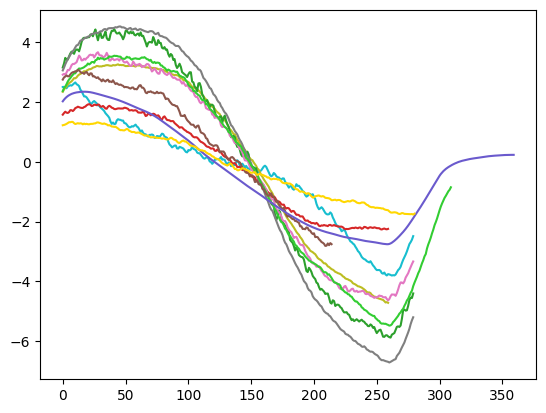

In [25]:
for i in np.arange(0,len(mdls)):
    plt.plot(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['nbp']),41),color=colors[i],label=mdls[i])

<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/862944953.py:24: SyntaxWarning: invalid escape sequence '\D'
  axs[3*i].set_ylabel('$\Delta$ Carbon\n[PgC/yr]')


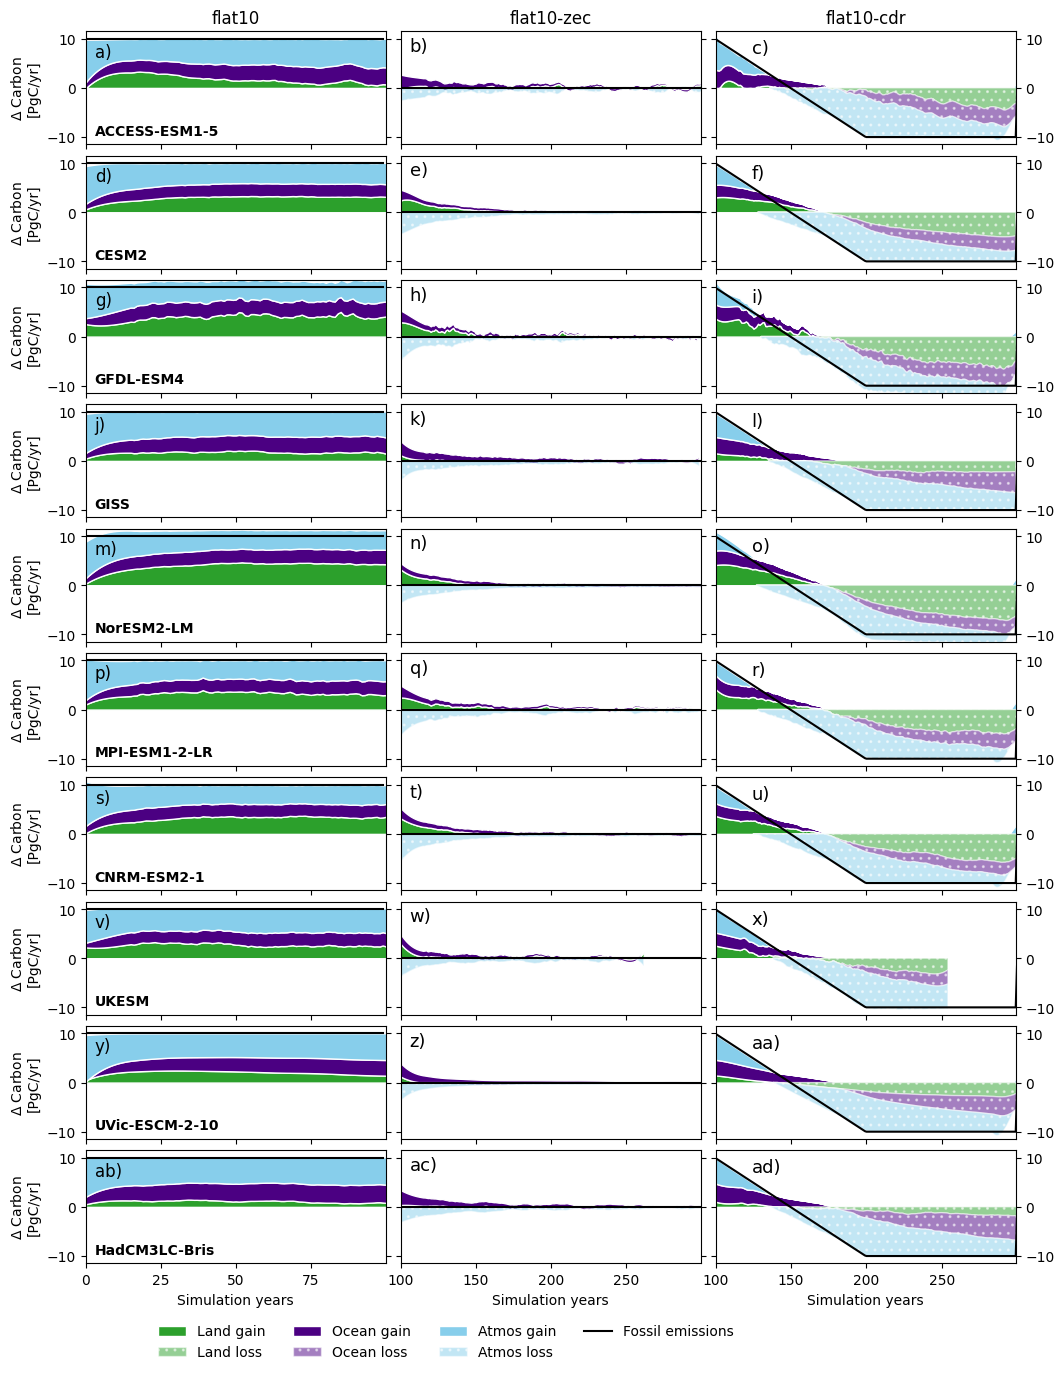

In [26]:
from scipy.signal import savgol_filter
fls_c1 = ['a)','d)','g)','j)','m)','p)','s)','v)','y)','ab)']
fls_c2 = ['b)','e)','h)','k)','n)','q)','t)','w)','z)','ac)']
fls_c3 = ['c)','f)','i)','l)','o)','r)','u)','x)','aa)','ad)']

fig, axs = plt.subplots(10, 3,figsize=[12,16])
axs=axs.flatten()
for i,m in enumerate(mdls):
    #print(m)
    
    tmpa=ed[m]['flat10']['C_atm'].diff('year').pad(year=(0,1),constant_values=0).copy()
    tmpa[-1]=tmpa[-2]
    tmpl=ed[m]['flat10']['nbp'].copy()
    tmpo=ed[m]['flat10']['fgco2'].copy()

    stmpa = savgol_filter(tmpa[1:].squeeze(drop=True), 31, 3) 
    stmpl = savgol_filter(tmpl[1:].squeeze(drop=True), 31, 3)
    stmpo = savgol_filter(tmpo[1:].squeeze(drop=True), 31, 3) 

    axs[3*i].stackplot(np.arange(0,len(tmpa)-1),stmpl,stmpo,stmpa,colors=['tab:green','indigo','skyblue'],edgecolor="white")

    if i==0:
        axs[3*i].set_title('flat10')
    axs[3*i].set_ylabel('$\Delta$ Carbon\n[PgC/yr]')     
    axs[3*i].set_xlim([0,100])
    axs[3*i].set_ylim([-11.5,11.5])
    #axs[3*i].grid()
    axs[3*i].plot(e_flat10['Emission Rate (PgC a-1)'][:100].values,'k')
    axs[3*i].set_xticks([0,25,50,75])
    if i in (0, 1, 2, 3, 4,5,6,7,8):
        axs[3*i].xaxis.set_ticklabels([])
    axs[3*i].annotate(m, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=10, ha='left', va='center', weight="bold")
    axs[3*i].annotate(fls_c1[i], xy=(0.03, 0.82), xycoords='axes fraction', fontsize=12, ha='left', va='center')
    axs[3*i].tick_params(right=True)
    if i==9:
        axs[3*i].set_xlabel('Simulation years')

    try:
        tmpa=ed[m]['flat10-zec']['C_atm'].diff('year').pad(year=(0,1)).copy()
        tmpa[-1]=tmpa[-2]
        tmpl=ed[m]['flat10-zec']['nbp'].copy()
        tmpo=ed[m]['flat10-zec']['fgco2'].copy()
        
        stmpa = savgol_filter(tmpa[100:].squeeze(drop=True), 31, 3) 
        stmpl = savgol_filter(tmpl[100:].squeeze(drop=True), 31, 3)
        stmpo = savgol_filter(tmpo[100:].squeeze(drop=True), 31, 3)
    
        axs[3*i+1].stackplot(np.arange(0,len(stmpa)),stmpl,stmpo,colors=['tab:green','indigo','skyblue'],edgecolor="white")
        ppp=axs[3*i+1].stackplot(np.arange(0,len(stmpa)),stmpa,colors=['skyblue'])
        ppp[0].set_hatch("..")
        ppp[0].set_alpha(0.5)
        ppp[0].set_edgecolor('w')
        
    except:
        0
    if i==0:
        axs[3*i+1].set_title('flat10-zec')
    axs[3*i+1].set_xlim([0,200])
    #axs[3*i+1].grid() 
    axs[3*i+1].set_ylim([-11.5,11.5])
    axs[3*i+1].plot(e_flat10_zec['Emission Rate (PgC a-1)'][100:].values,'k')
    axs[3*i+1].set_xticks([0,50,100,150])
    axs[3*i+1].set_xticklabels([100,150,200,250])
    if i in (0, 1, 2, 3, 4,5,6,7,8):
        axs[3*i+1].xaxis.set_ticklabels([])
    axs[3*i+1].yaxis.set_ticklabels([])
    axs[3*i+1].tick_params(right=True)
    axs[3*i+1].annotate(fls_c2[i], xy=(0.03, 0.87), xycoords='axes fraction', fontsize=13, ha='left', va='center')
    if i==9:
        axs[3*i+1].set_xlabel('Simulation years')
    
    try:
        tmpa=ed[m]['flat10-cdr']['C_atm'].diff('year').pad(year=(0,1)).copy()
        tmpa[-1]=tmpa[-2]
        tmpl=ed[m]['flat10-cdr']['nbp'].copy()
        tmpo=ed[m]['flat10-cdr']['fgco2'].copy()
        if m=='NorESM2-LM':
            tmpa[16]=tmpa[15]
            tmpa[17]=tmpa[18]
        #    tmpo[:17]=10-tmpl[:17]-tmpa[:17]
        stmpa = savgol_filter(tmpa[100:].squeeze(drop=True), 31, 3) 
        stmpl = savgol_filter(tmpl[100:].squeeze(drop=True), 31, 3) 
        stmpo = savgol_filter(tmpo[100:].squeeze(drop=True), 31, 3) 
        
        stmpa_neg=np.clip(stmpa,-1e10,0)
        stmpa_pos=np.clip(stmpa,0,1e10)
        stmpo_neg=np.clip(stmpo,-1e10,0)
        stmpo_pos=np.clip(stmpo,0,1e10)
        stmpl_neg=np.clip(stmpl,-1e10,0)
        stmpl_pos=np.clip(stmpl,0,1e10)
        crs1=np.argmin(stmpa_pos>0)
        crs2=np.argmin(stmpl_pos>0)
        
        axs[3*i+2].stackplot(np.arange(0,len(stmpa)),stmpl_pos[:],stmpo_pos[:],stmpa_pos[:],colors=['tab:green','indigo','skyblue'],labels=['Land gain','Ocean gain','Atmos gain'],edgecolor="white")

        pp3=axs[3*i+2].stackplot(np.arange(crs1,len(stmpa)),stmpl_neg[crs1:],stmpo_neg[crs1:],stmpa_neg[crs1:],colors=['tab:green','indigo','skyblue'],labels=['Land loss','Ocean loss','Atmos loss'],edgecolor="white")
        for pp in pp3:
            pp.set_hatch("..")  
            pp.set_edgecolor('w')  
            pp.set_alpha(0.5)
        
    except:
        0
    if i==0:
        axs[3*i+2].set_title('flat10-cdr')
    axs[3*i+2].set_xlim([0,199])
    #axs[3*i+2].grid() 
    axs[3*i+2].set_ylim([-11.5,11.5])
    axs[3*i+2].yaxis.set_label_position("right")
    axs[3*i+2].yaxis.tick_right()
    axs[3*i+2].set_xticks([0,50,100,150])
    axs[3*i+2].set_xticklabels([100,150,200,250])
    if i in (0, 1, 2, 3, 4,5,6,7,8):
        axs[3*i+2].xaxis.set_ticklabels([])
    axs[3*i+2].tick_params(left=True)
    axs[3*i+2].annotate(fls_c3[i], xy=(0.12, 0.85), xycoords='axes fraction', fontsize=13, ha='left', va='center')
    if i==9:
        axs[3*i+2].set_xlabel('Simulation years')
    
    axs[3*i+2].plot(e_flat10_cdr['Emission Rate (PgC a-1)'][100:].values,'k',label='Fossil emissions')
    

    # legend
    handles, labels = axs[3*i+2].get_legend_handles_labels()
    order = [0,3,1,4,2,5,6]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, bbox_to_anchor=(-1.9, -0.43), loc='upper left', ncol=4)

#plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.1)

plt.savefig("images/flat10_ESM_results_carbon_fluxes.pdf", bbox_inches='tight')
plt.savefig("images/flat10_ESM_results_carbon_fluxes.jpg", bbox_inches='tight')


In [27]:
#run plot_c4mip to recreate these csvs
tas_1pct=pd.read_csv('c4mip_tas.csv',index_col=0)
ce_1pct=pd.read_csv('c4mip_emis.csv',index_col=0,delimiter=';')
mdls_1pct=ce_1pct.columns

<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:65: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:65: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/462555669.py:50: SyntaxWarning: invalid escape sequence '\D'
  ax[2].set_ylabel('$\Delta$ Temperature (K)')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/462555669.py:65: SyntaxWarning: invalid escape sequence '\D'
  ax[3].set_ylabel('$\Delta$ Temperature (K)')


66
65
66
65
62
65
65
66


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/462555669.py:92: RuntimeWarning: divide by zero encountered in divide
  ax[5].plot((ed[m]['flat10']['co2']-278).to_numpy().flatten()*2.13/(np.arange(0,len(ed[m]['flat10']['co2']))*10)[:],label=m,color=colors[n])


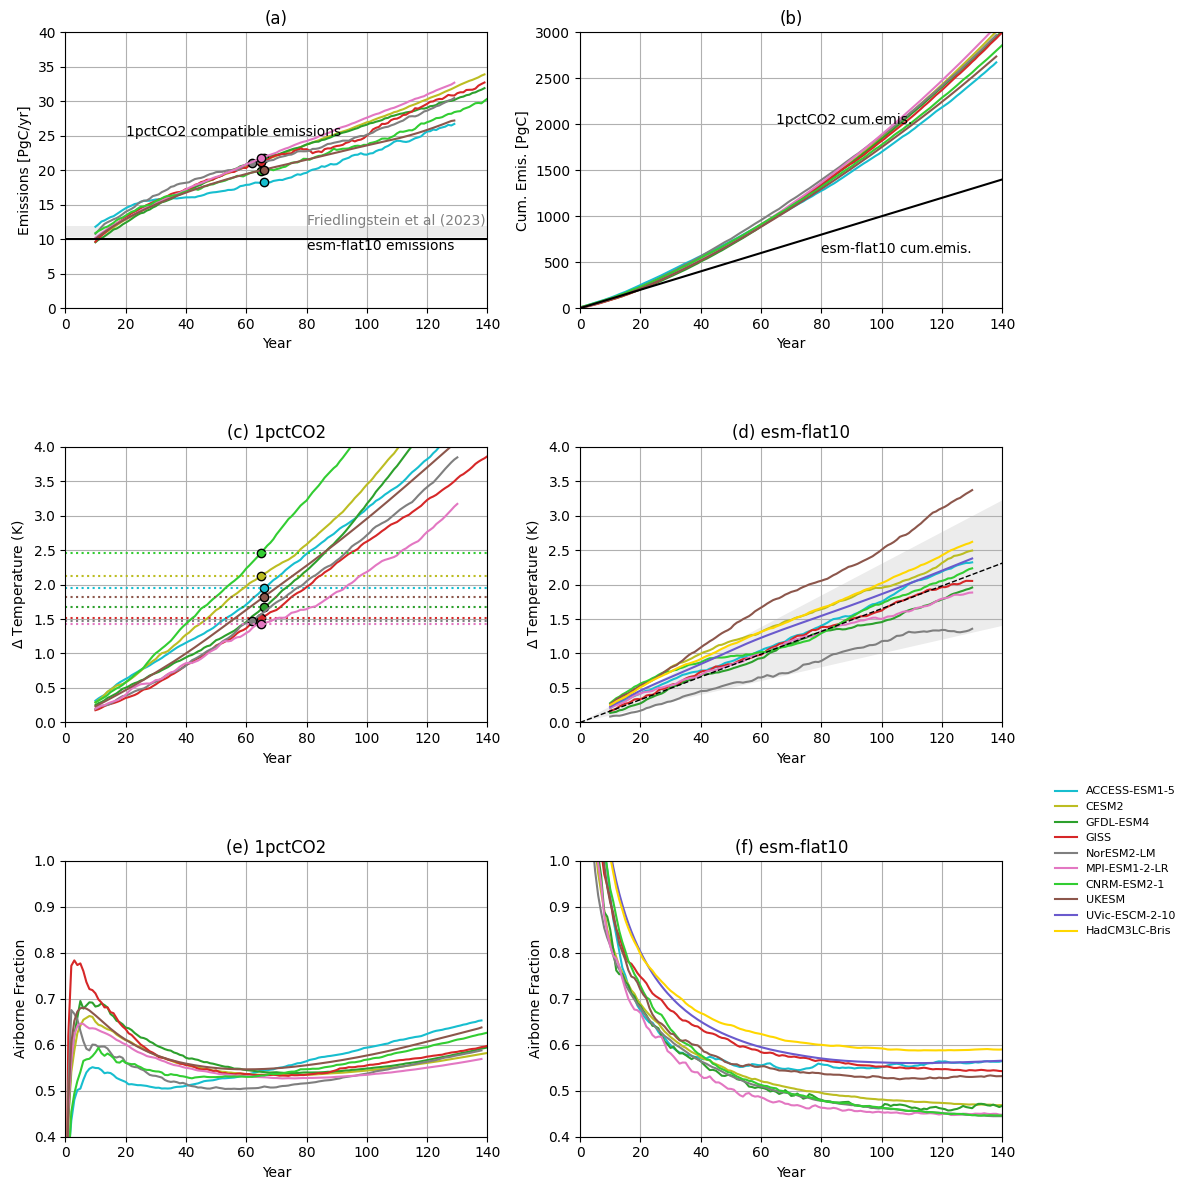

In [28]:
fig, axes = plt.subplots(3,2,figsize=(12, 12))
ax=axes.flatten()

for n,m in enumerate(mdls_1pct):
    mi=mdls.index(m)
    tmp=ce_1pct[m].rolling(window=20,center=True).mean()
    ax[0].plot(tmp,color=colors[n])
    ytmp=np.argmax(ce_1pct[m].cumsum()>1000)
    ax[0].plot([ytmp],ce_1pct[m].rolling(window=20,center=True).mean().iloc[ytmp],marker='o',markerfacecolor=colors[n],markeredgecolor='k',label=m)

ax[0].axhline(10,linestyle='-',color='k',label='flat10')
ax[0].fill_between(np.arange(0,320), 11.1-0.8, 11.1+0.8, color="gray", alpha=0.15, edgecolor="none")

ax[0].set_ylabel('Emissions [PgC/yr]')
ax[0].set_xlabel('Year')
ax[0].set_ylim(0,40)
ax[0].set_xlim(0,140)
ax[0].set_title('(a)')
ax[0].text(20,25,'1pctCO2 compatible emissions',fontsize=10)
ax[0].text(80,8.5,'esm-flat10 emissions',fontsize=10)
ax[0].text(80,12,'Friedlingstein et al (2023)',fontsize=10,color='gray')

ax[0].grid()

for n,m in enumerate(mdls_1pct):
    ce_1pct[m].cumsum().plot(color=colors[n],ax=ax[1],label=m)
ax[1].set_ylabel('Cum. Emis. [PgC]')
#ax[1].axhline(1000,linestyle='--',color='k')
#ax[1].axhline(500,linestyle=':',color='k')

ax[1].set_xlabel('Year')
ax[1].set_ylim(0,3000)
ax[1].set_xlim(0,140)
ax[1].plot([0,140],[0,1400],'k',label='flat10')
ax[1].text(80,600,'esm-flat10 cum.emis.',fontsize=10)
ax[1].text(65,2000,'1pctCO2 cum.emis.',fontsize=10)

ax[1].set_title('(b)')
#ax[1].legend()
ax[1].grid()
for n,m in enumerate(mdls_1pct):
    ytmp=np.argmax(ce_1pct[m].cumsum()>1000)
    print(ytmp)
    t0=tas_1pct[m][0:20].mean()-(tas_1pct[m][10:30].mean()-tas_1pct[m][0:20].mean())
    (tas_1pct[m]-t0).rolling(window=20,center=True).mean().plot(color=colors[n],ax=ax[2])

    ax[2].plot([ytmp],(tas_1pct[m]-t0).rolling(window=20,center=True).mean().iloc[ytmp],marker='o',markerfacecolor=colors[n],markeredgecolor='k',label=m)
    ax[2].axhline((tas_1pct[m]-t0).rolling(window=20,center=True).mean().iloc[ytmp],linestyle=':',color=colors[n])

ax[2].set_ylabel('$\Delta$ Temperature (K)')
ax[2].set_xlabel('Year')
ax[2].set_ylim(0,4)
ax[2].set_xlim(0,140)
ax[2].set_title('(c) 1pctCO2')
ax[2].grid()
for i,m in enumerate(mdls):

    cn0=ed[m]['flat10']['tas'][:20].mean()-(ed[m]['flat10']['tas'][10:30:1].mean()-ed[m]['flat10']['tas'][:20].mean())
    ax[3].plot(ed[m]['flat10']['tas'][:140].rolling(year=20,center=True).mean()-cn0,color=mcols[i],label=m)

    ax[3].plot([100],ed[m]['flat10']['tas'][:100].rolling(year=20,center=True).mean()[99]-cn0,marker='o',markerfacecolor=colors[i],markeredgecolor='k')
    ax[3].axhline(ed[m]['flat10']['tas'][:100].rolling(year=20,center=True).mean()[99]-cn0,linestyle=':',color=colors[i])
    

ax[3].set_ylabel('$\Delta$ Temperature (K)')
ax[3].set_xlabel('Year')
ax[3].set_ylim(0,4)
ax[3].set_xlim(0,140)
#ax[3].legend()

ax[3].plot(np.arange(0,300)*10*1.65/1000, color='black', lw=1, linestyle="--")
ax[3].fill_between(np.arange(0,320), np.arange(0,320)*10*1.0/1000, np.arange(0,320)*10*2.3/1000, color="gray", alpha=0.15, edgecolor="none")

ax[3].set_title('(d) esm-flat10')
ax[3].grid()




for n,m in enumerate(mdls_1pct):
    ax[4].plot(((278*1.01**np.arange(0,len(ce_1pct[m])))-278)*2.13/ce_1pct[m].cumsum(),label=m,color=colors[n])
ax[4].set_ylim(.4,1)
ax[4].set_xlim(0,140)
ax[4].set_xticks([0,20,40,60,80,100,120,140])
ax[4].set_xticklabels([0,20,40,60,80,100,120,140])

ax[4].set_ylabel('Airborne Fraction')
ax[4].set_xlabel('Year')
ax[4].set_title('(e) 1pctCO2')
ax[4].grid()
for n,m in enumerate(mdls):
    ax[5].plot((ed[m]['flat10']['co2']-278).to_numpy().flatten()*2.13/(np.arange(0,len(ed[m]['flat10']['co2']))*10)[:],label=m,color=colors[n])
ax[5].set_ylim(.4,1)
ax[5].set_xlim(0,140)
ax[5].set_ylabel('Airborne Fraction')
ax[5].set_title('(f) esm-flat10')
ax[5].set_xlabel('Year')

ax[5].legend(frameon=False, prop={'size': 8}, bbox_to_anchor=(1.1, 0.69))
ax[5].grid()
plt.tight_layout()

Tables

In [29]:
def conv2siunitx(val, err1, err2):
    val = "{0:0.2f}".format(val)
    err1 = "{0:0.2f}".format(err1)
    err2 = "{0:0.2f}".format(err2)

    return(val+'('+err1+','+err2+')')
def make_synth(mgc_met):
    tmp=mgc_met.iloc[0].copy().astype('str')
    for i,v in enumerate(mgc_met.columns.values):
        tmp.iloc[i]=conv2siunitx(mgc_met.iloc[1,i],mgc_met.iloc[0,i],mgc_met.iloc[2,i])
    return tmp

In [30]:
tcre100f=ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
tcre100m=ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
tcre100c=ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=100)


zec50f=ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=150)-ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
zec50m=ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=150)-ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
zec50c=ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=150)-ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=100)


zec100f=ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=200)-ds_fair.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
zec100m=ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=200)-ds_magicc.temperature.sel(scenario='esm-flat10_zec').isel(time=100)
zec100c=ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=200)-ds_cicero.temperature.sel(scenario='esm-flat10_zec').isel(time=100)

In [31]:
fair_metrics_1pct=pd.read_csv('SCM_data/metrics/FaIR_metrics.csv',index_col=0)
magicc_metrics_1pct=pd.read_csv('SCM_data/metrics/MAGICC_metrics.csv',index_col=0)

cicero_metrics_1pct=pd.DataFrame(np.vstack([ds_cicero['tcre'].values,ds_cicero['zec50'].values,ds_cicero['zec100'].values]),index=['tcre','zec50','zec100']).T
cicero_metrics_1pct.iloc[np.abs(ds_cicero['tcre']-ds_cicero['temperature'].isel({'time':100}).sel({'scenario':'esm-flat10'}))>0.1]=np.NaN
cicero_metrics_1pct.iloc[np.abs(cicero_metrics_1pct['zec100']+cicero_metrics_1pct['tcre']-(zec100c+tcre100c))>0.5]=np.NaN


In [32]:
cicero_metrics_flat10 = pd.DataFrame()
fair_metrics_flat10 = pd.DataFrame()
magicc_metrics_flat10 = pd.DataFrame()



cicero_metrics_flat10['tcre']=tcre100c
fair_metrics_flat10['tcre']=tcre100f    
magicc_metrics_flat10['tcre']=tcre100m

cicero_metrics_flat10['zec50']=zec50c
fair_metrics_flat10['zec50']=zec50f
magicc_metrics_flat10['zec50']=zec50m

cicero_metrics_flat10['zec100']=zec100c
fair_metrics_flat10['zec100']=zec100f
magicc_metrics_flat10['zec100']=zec100m

cicero_metrics_flat10['tpw']=ds_cicero['temperature'].sel({'scenario':'esm-flat10_cdr'}).argmax('time').values-150
fair_metrics_flat10['tpw']=ds_fair['temperature'].sel({'scenario':'esm-flat10_cdr'}).argmax('time').values-150
magicc_metrics_flat10['tpw']=ds_magicc['temperature'].sel({'scenario':'esm-flat10_cdr'}).argmax('time').values-150

cicero_metrics_flat10['tnz']=ds_cicero['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':150})-ds_cicero['temperature'].sel({'scenario':'esm-flat10'}).isel({'time':125})
fair_metrics_flat10['tnz']=ds_fair['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':150})-ds_fair['temperature'].sel({'scenario':'esm-flat10'}).isel({'time':125})
magicc_metrics_flat10['tnz']=ds_magicc['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':150})-ds_magicc['temperature'].sel({'scenario':'esm-flat10'}).isel({'time':125})

cicero_metrics_flat10['tr1000']=ds_cicero['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':200})-ds_cicero['temperature'].sel({'scenario':'esm-flat10'}).isel({'time':100})
fair_metrics_flat10['tr1000']=ds_fair['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':200})-ds_fair['temperature'].sel({'scenario':'esm-flat10'}).isel({'time':100})
magicc_metrics_flat10['tr1000']=ds_magicc['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':200})-ds_magicc['temperature'].sel({'scenario':'esm-flat10'}).isel({'time':100})

cicero_metrics_flat10['tr0']=ds_cicero['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':300})
fair_metrics_flat10['tr0']=ds_fair['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':300})
magicc_metrics_flat10['tr0']=ds_magicc['temperature'].sel({'scenario':'esm-flat10_cdr'}).isel({'time':300})





cicero_metrics_flat10['model']='CICERO'
fair_metrics_flat10['model']='FAIR'
magicc_metrics_flat10['model']='MAGICC'



l=[cicero_metrics_flat10,fair_metrics_flat10,magicc_metrics_flat10]

scm_metrics_flat10=pd.concat(l,axis=0)



In [33]:
l=[cicero_metrics_flat10,fair_metrics_flat10,magicc_metrics_flat10]

scm_metrics_flat10=pd.concat(l,axis=0)

In [34]:
cic_met=scm_metrics_flat10[scm_metrics_flat10['model']=='CICERO'].iloc[:,:-1].quantile([0.05,0.5,0.95])
fair_met=scm_metrics_flat10[scm_metrics_flat10['model']=='FAIR'].iloc[:,:-1].quantile([0.05,0.5,0.95])
mgc_met=scm_metrics_flat10[scm_metrics_flat10['model']=='MAGICC'].iloc[:,:-1].quantile([0.05,0.5,0.95])



In [35]:
scm_summ_1pct=pd.DataFrame({})
scm_summ_1pct['MAGICC']=make_synth(magicc_metrics_1pct.loc[:,['tcre_1pctco2','zec50_esm-1pct-brch-1000pgc','zec100_esm-1pct-brch-1000pgc']].quantile([0.05,0.5,0.95]))

scm_summ_1pct['FaIR']=make_synth(fair_metrics_1pct.loc[:,['tcre','zec50','zec100']].quantile([0.05,0.5,0.95])).values

scm_summ_1pct['CICERO-SCM']=make_synth(cicero_metrics_1pct.loc[:,['tcre','zec50','zec100']].quantile([0.05,0.5,0.95])).values

scm_summ_1pct=scm_summ_1pct.T

scm_summ_1pct

,tcre_1pctco2,zec50_esm-1pct-brch-1000pgc,zec100_esm-1pct-brch-1000pgc
MAGICC,"1.71(1.13,2.68)","-0.12(-0.28,0.19)","-0.18(-0.44,0.22)"
FaIR,"1.57(1.16,2.10)","-0.02(-0.19,0.34)","-0.04(-0.28,0.48)"
CICERO-SCM,"1.69(1.33,2.21)","-0.05(-0.13,0.09)","-0.25(-0.33,-0.11)"


In [36]:
scm_summ=pd.DataFrame({})
scm_summ['MAGICC']=make_synth(mgc_met)
scm_summ['FaIR']=make_synth(fair_met)
scm_summ['CICERO-SCM']=make_synth(cic_met)
scm_summ=scm_summ.T

scm_summ

,tcre,zec50,zec100,tpw,tnz,tr1000,tr0
MAGICC,"1.59(1.05,2.66)","-0.11(-0.23,0.12)","-0.16(-0.38,0.15)","-6.00(-13.05,8.00)","-0.04(-0.11,0.11)","-0.19(-0.43,0.27)","-0.56(-1.06,0.14)"
FaIR,"1.54(1.13,2.18)","-0.02(-0.13,0.25)","-0.03(-0.22,0.37)","0.00(-11.00,15.00)","0.01(-0.07,0.17)","-0.03(-0.26,0.48)","-0.15(-0.44,0.36)"
CICERO-SCM,"1.58(1.21,2.11)","-0.18(-0.26,-0.09)","-0.34(-0.47,-0.24)","-10.00(-16.00,-4.00)","-0.06(-0.11,0.00)","-0.35(-0.52,-0.20)","-0.79(-1.08,-0.61)"


ESM table

In [37]:

df_zec_1pct=pd.DataFrame()
data = {'Name': ['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS','NorESM2-LM','MPI-ESM1-2-LR','CNRM-CM6-1','UKESM', 'UVic-ESCM-2-10','HadCM3LC-Bris'],
        'TCRE': [1.9,2.0,1.45,1.6,1.32,1.65,1.73,2.55,1.8,np.nan],
      #  'TCR':[1.9,2.0,1.2,np.NaN,1.32,1.65,1.84],
      #  'CUMEM':[1064,1073,1066,np.NaN,1075,1127,1124],
        'ZEC50':[0.01,-.31,np.NaN,0.09,-.33,-.27,0.06,0.28,0.04,np.nan],
        'ZEC100':[-0.03,-.17,np.NaN,-0.06,-.32,-.37,0.25,0.33,0.02,np.nan]}
df_zec_1pct = pd.DataFrame(data)
df_zec_1pct 
df_zec_1pct.set_index('Name')


,TCRE,ZEC50,ZEC100
Name,,,
ACCESS-ESM1-5,1.90,0.01,-0.03
CESM2,2.00,-0.31,-0.17
GFDL-ESM4,1.45,NaN,NaN
GISS,1.60,0.09,-0.06
NorESM2-LM,1.32,-0.33,-0.32
MPI-ESM1-2-LR,1.65,-0.27,-0.37
CNRM-CM6-1,1.73,0.06,0.25
UKESM,2.55,0.28,0.33
UVic-ESCM-2-10,1.80,0.04,0.02


In [38]:
esm_tcre_flat10=np.zeros(len(mdls))
esm_zec50_flat10=np.zeros(len(mdls))
esm_zec100_flat10=np.zeros(len(mdls))
esm_tpw_flat10=np.zeros(len(mdls))
esm_tnz_flat10=np.zeros(len(mdls))
esm_tr1000_flat10=np.zeros(len(mdls))
esm_tr0_flat10=np.zeros(len(mdls))




for i,m in enumerate(mdls):
    cn0=ed[m]['flat10']['tas'][:20].mean()-(ed[m]['flat10']['tas'][10:30:1].mean()-ed[m]['flat10']['tas'][:20].mean())

    esm_tcre_flat10[i]=ed[m]['flat10']['tas'][90:110].mean().values-cn0
    esm_zec50_flat10[i]=(ed[m]['flat10-zec']['tas'][140:160].mean().values)-esm_tcre_flat10[i]
    esm_zec100_flat10[i]=(ed[m]['flat10-zec']['tas'][190:210].mean().values)-esm_tcre_flat10[i]

    # indicate max value
    mxy=np.max(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['tas']),window))
    esm_tpw_flat10[i] = np.where(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['tas']),window)==mxy)[0]-150
    esm_tnz_flat10[i] = ed[mdls[i]]['flat10-cdr']['tas'][140:160].mean().values-ed[mdls[i]]['flat10']['tas'][115:135].mean().values
    esm_tr1000_flat10[i] = ed[mdls[i]]['flat10-cdr']['tas'][190:210].mean().values-ed[mdls[i]]['flat10']['tas'][90:110].mean().values
    esm_tr0_flat10[i] = ed[mdls[i]]['flat10-cdr']['tas'][290:310].mean().values

    

print("TCRE:", esm_tcre_flat10)
print("ZEC50:", esm_zec50_flat10)
print("ZEC100:", esm_zec100_flat10)
print("TPW:", esm_tpw_flat10)
print("TNZ:", esm_tnz_flat10)
print("TR1000:", esm_tr1000_flat10)
print("TR0:", esm_tr0_flat10)
esm_metrics_flat10 = pd.DataFrame({})
esm_metrics_flat10['tcre']=esm_tcre_flat10
esm_metrics_flat10['zec50']=esm_zec50_flat10
esm_metrics_flat10['zec100']=esm_zec100_flat10
esm_metrics_flat10['tpw']=esm_tpw_flat10
esm_metrics_flat10['tnz']=esm_tnz_flat10
esm_metrics_flat10['tr1000']=esm_tr1000_flat10
esm_metrics_flat10['tr0']=esm_tr0_flat10


esm_metrics_flat10.index=mdls
pd.set_option('display.precision', 2)

esm_metrics_flat10

TCRE: [1.75301063 1.95146945 1.45465386 1.62163849 1.17821122 1.50077057
 1.72289277 2.503865   1.86102962 2.02051318]
ZEC50: [ 0.20830381 -0.2631313  -0.20984793 -0.18912964 -0.22547232 -0.13938904
  0.00142626  0.272745    0.059901    0.0960024 ]
ZEC100: [ 0.13327324 -0.12651117 -0.1135391  -0.24052734 -0.31327247 -0.2394135
  0.10518711  0.20698     0.1190201   0.15074751]
TPW: [  7. -10. -29.  -4. -33.   1. -10.  -1.   3.  11.]
TNZ: [ 0.08160996  0.05382003 -0.09170842  0.12097321 -0.02551466 -0.06321108
  0.10861629  0.162655    0.07346749 -0.03127059]
TR1000: [ 0.23198843  0.029688   -0.25358582  0.01142578 -0.22908808 -0.23681939
  0.02917725  0.48317     0.19768906  0.16988671]
TR0: [ 0.17284241  0.41951067 -0.1129776  -0.56428833 -0.30888033 -0.29384002
  0.37563933         nan  0.25246087  0.14777742]


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/4221240321.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  esm_tpw_flat10[i] = np.where(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['tas']),window)==mxy)[0]-150
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/4221240321.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  esm_tpw_flat10[i] = np.where(moving_average(np.squeeze(ed[mdls[i]]['flat10-cdr']['tas']),window)==mxy)[0]-150
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/4221240321.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and 

,tcre,zec50,zec100,tpw,tnz,tr1000,tr0
ACCESS-ESM1-5,1.75,2.08e-01,0.13,7.0,0.08,0.23,0.17
CESM2,1.95,-2.63e-01,-0.13,-10.0,0.05,0.03,0.42
GFDL-ESM4,1.45,-2.10e-01,-0.11,-29.0,-0.09,-0.25,-0.11
GISS,1.62,-1.89e-01,-0.24,-4.0,0.12,0.01,-0.56
NorESM2-LM,1.18,-2.25e-01,-0.31,-33.0,-0.03,-0.23,-0.31
MPI-ESM1-2-LR,1.50,-1.39e-01,-0.24,1.0,-0.06,-0.24,-0.29
CNRM-ESM2-1,1.72,1.43e-03,0.11,-10.0,0.11,0.03,0.38
UKESM,2.50,2.73e-01,0.21,-1.0,0.16,0.48,NaN
UVic-ESCM-2-10,1.86,5.99e-02,0.12,3.0,0.07,0.20,0.25
HadCM3LC-Bris,2.02,9.60e-02,0.15,11.0,-0.03,0.17,0.15


In [39]:
def vp(data,pos,color,side,nm):
        data=data[~np.isnan(data)]

        parts=plt.violinplot(data,positions=[pos],showmeans=True,widths=.25, side=side)
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_color(color)
        for partname in ('cbars','cmins','cmaxes','cmeans'):
            vp = parts[partname]
            vp.set_edgecolor(color)
            vp.set_linewidth(1)
        if side=='low':
            pc.set_alpha(0.95)
            plt.text(pos-0.04, 3, 'flat10', color=color, fontsize=8, ha='center', va='top',rotation=90)
            plt.text(pos, data.mean(),'{0:.2f}'.format(data.mean().values), color='w', fontsize=6, ha='right', va='bottom')
            plt.text(pos-0.01, 3.5, nm, color='black', fontsize=10, ha='right', va='bottom',rotation=90)
        else:
            pc.set_alpha(0.75)
            plt.text(pos+0.04,3, '1pctco2', color=color, fontsize=8, ha='center', va='top',rotation=90)
            plt.text(pos, data.mean(),'{0:.2f}'.format(np.mean(data)), color='w', fontsize=6, ha='left', va='bottom')
            plt.text(pos+0.01, 3.5, nm, color='black', fontsize=10, ha='left', va='bottom',rotation=90)

       

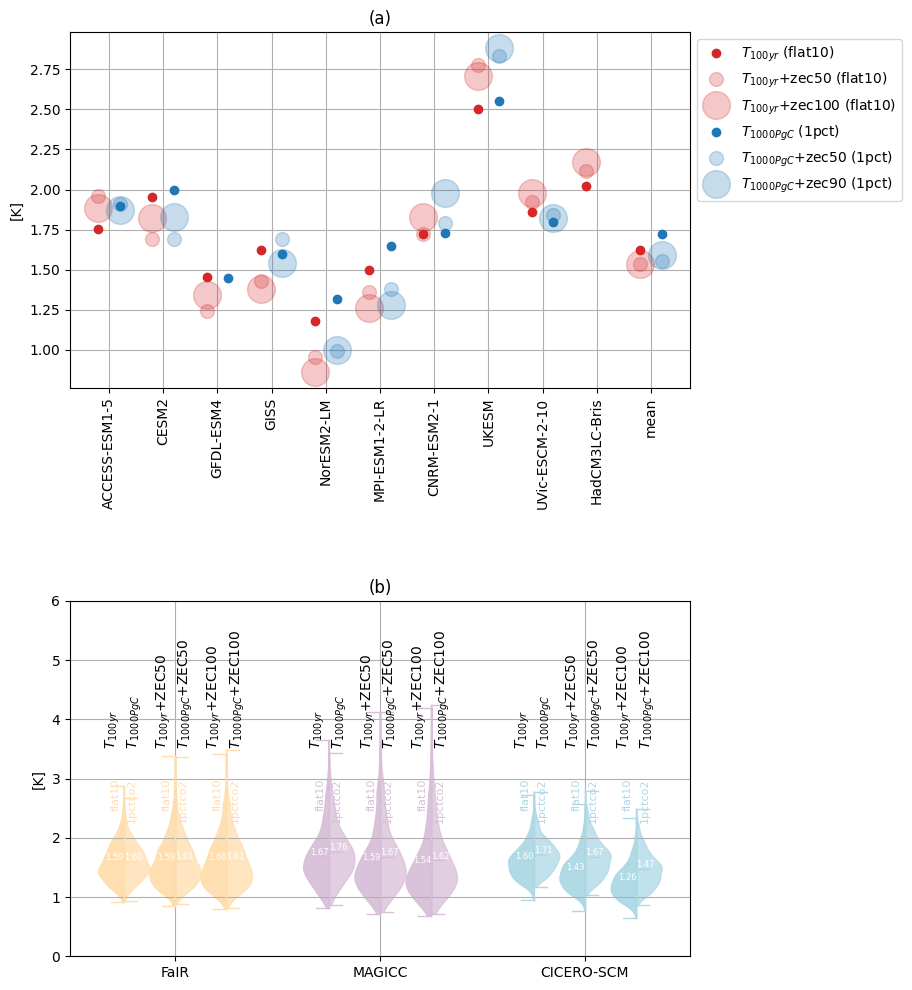

In [40]:
fig, axs = plt.subplots(2,1,figsize=[8,12])

plt.axes(axs[0])

weight_counts={'TCRE':np.hstack([df_zec_1pct['TCRE'].values,df_zec_1pct['TCRE'].iloc[[0,1,4,5,6]].mean()]),'ZEC50':np.hstack([df_zec_1pct['ZEC50'].values,df_zec_1pct['ZEC50'].iloc[[0,1,4,5,6]].mean()]),'ZEC100':np.hstack([(df_zec_1pct['ZEC100'].values-df_zec_1pct['ZEC50'].values),(df_zec_1pct['ZEC100'].iloc[[0,1,4,5,6]].mean()-df_zec_1pct['ZEC50'].iloc[[0,1,4,5,6]].mean())])}

weight_counts_f10={'TCRE':np.hstack([esm_metrics_flat10.loc[:,'tcre'].values,esm_metrics_flat10.loc[:,'tcre'].iloc[[0,1,4,5,6]].mean()]),'ZEC50':np.hstack([esm_metrics_flat10.loc[:,'zec50'].values,esm_metrics_flat10.loc[:,'zec50'].iloc[[0,1,4,5,6]].mean()]),'ZEC100':np.hstack([(esm_metrics_flat10.loc[:,'zec100'].values-esm_metrics_flat10.loc[:,'zec50'].values),(esm_metrics_flat10.loc[:,'zec100'].iloc[[0,1,4,5,6]].mean()-esm_metrics_flat10.loc[:,'zec50'].iloc[[0,1,4,5,6]].mean())])}


mdlsp=mdls+['mean']
x = np.arange(len(mdlsp))  # the label locations

bottom = np.zeros(len(mdlsp))
p=['']*6
i=0
for boolean, weight_count in weight_counts_f10.items():
    if i==0:
        pl= plt.plot(x-.2, weight_count,'o',color='tab:red',markerfacecolor='tab:red',label='$T_{100yr}$ (flat10)')
        p[0]=pl[0]
    else:
        tmp=np.sign(weight_count)
        tmpc=np.repeat(['tab:grey'],len(mdlsp))
        tmpc[np.where(tmp==-1)[0]]='tab:blue'
        tmpc[np.where(tmp==1)[0]]='tab:red'
    if i==1:
        for j,w in enumerate(weight_count):
            pl = plt.plot(x[j]-.2, [bottom[j]+w],color='tab:red',marker='o',markersize=10,linestyle='none',alpha=0.25,label='$T_{100yr}$+zec50 (flat10)')
            p[1]=pl[0]
    if i==2:
        for j,w in enumerate(weight_count):
            pl = plt.plot(x[j]-.2, [bottom[j]+w],color='tab:red',marker='o',markersize=20,linestyle='none',alpha=0.25,label='$T_{100yr}$+zec100 (flat10)')
            p[2]=pl[0]
      
    bottom += weight_count
    i +=1

bottom = np.zeros(len(mdlsp))
i=0
for boolean, weight_count in weight_counts.items():
    if i==0:
        pl = plt.plot(x+.2, weight_count,'o',color='tab:blue',markerfacecolor='tab:blue',label='$T_{1000PgC}$ (1pct)')
        p[3]=pl[0]
    else:
        tmp=np.sign(weight_count)
        tmpc=np.repeat(['tab:grey'],len(mdlsp))
        tmpc[np.where(tmp==-1)[0]]='tab:blue'
        tmpc[np.where(tmp==1)[0]]='tab:red'
    if i==1:
        for j,w in enumerate(weight_count):
            pl = plt.plot(x[j]+.2, bottom[j]+w,color='tab:blue',marker='o',markersize=10,linestyle='none',label='$T_{1000PgC}$+zec50 (1pct)',alpha=0.25)
            p[4]=pl[0]
    if i==2:
        for j,w in enumerate(weight_count):
            pl = plt.plot(x[j]+.2, bottom[j]+w,color='tab:blue',marker='o',markersize=20,linestyle='none',label='$T_{1000PgC}$+zec90 (1pct)',alpha=0.25)
            p[5]=pl[0]
      
    bottom += weight_count
    i +=1



plt.grid()
plt.xticks(x, mdlsp, rotation=90)
plt.ylabel('[K]')
plt.legend(p, [p_.__getattribute__('get_label')() for p_ in p],loc='upper left',bbox_to_anchor=(1,1))
plt.title('(a)')
plt.axes(axs[1])




vp(fair_metrics_1pct['tcre'],-.25,'navajowhite','high','$T_{1000PgC}$')
vp(magicc_metrics_1pct['tcre_1pctco2'],1-.25,'thistle','high','$T_{1000PgC}$')
vp(cicero_metrics_1pct['tcre'],2-.25,'lightblue','high','$T_{1000PgC}$')


vp(tcre100f,-.25,'navajowhite','low','$T_{100yr}$')
vp(tcre100m,1-.25,'thistle','low','$T_{100yr}$')
vp(tcre100c,2-.25,'lightblue','low','$T_{100yr}$')



vp(fair_metrics_1pct['tcre']+fair_metrics_1pct['zec50'],0,'navajowhite','high','$T_{1000PgC}$+ZEC50')
vp(magicc_metrics_1pct['tcre_1pctco2']+magicc_metrics_1pct['zec50_esm-1pct-brch-1000pgc'],1,'thistle','high','$T_{1000PgC}$+ZEC50')
vp(cicero_metrics_1pct['tcre']+cicero_metrics_1pct['zec50'],2,'lightblue','high','$T_{1000PgC}$+ZEC50')


vp(tcre100f+zec50f,0,'navajowhite','low','$T_{100yr}$+ZEC50')
vp(tcre100m+zec50m,1,'thistle','low','$T_{100yr}$+ZEC50')
vp(tcre100c+zec50c,2,'lightblue','low','$T_{100yr}$+ZEC50')

vp(fair_metrics_1pct['tcre']+fair_metrics_1pct['zec100'],0+.25,'navajowhite','high','$T_{1000PgC}$+ZEC100')
vp(magicc_metrics_1pct['tcre_1pctco2']+magicc_metrics_1pct['zec100_esm-1pct-brch-1000pgc'],1+.25,'thistle','high','$T_{1000PgC}$+ZEC100')
vp(cicero_metrics_1pct['tcre']+cicero_metrics_1pct['zec100'],2+.25,'lightblue','high','$T_{1000PgC}$+ZEC100')


vp(tcre100f+zec100f,0+.25,'navajowhite','low','$T_{100yr}$+ZEC100')
vp(tcre100m+zec100m,1+.25,'thistle','low','$T_{100yr}$+ZEC100')
vp(tcre100c+zec100c,2+.25,'lightblue','low','$T_{100yr}$+ZEC100')

plt.xticks([0,1,2],['FaIR','MAGICC','CICERO-SCM'])
plt.ylim(0,6)
plt.grid()
plt.ylabel('[K]')
plt.title('(b)')
fig.subplots_adjust(wspace=0.3, hspace=0.6)

Figure 7

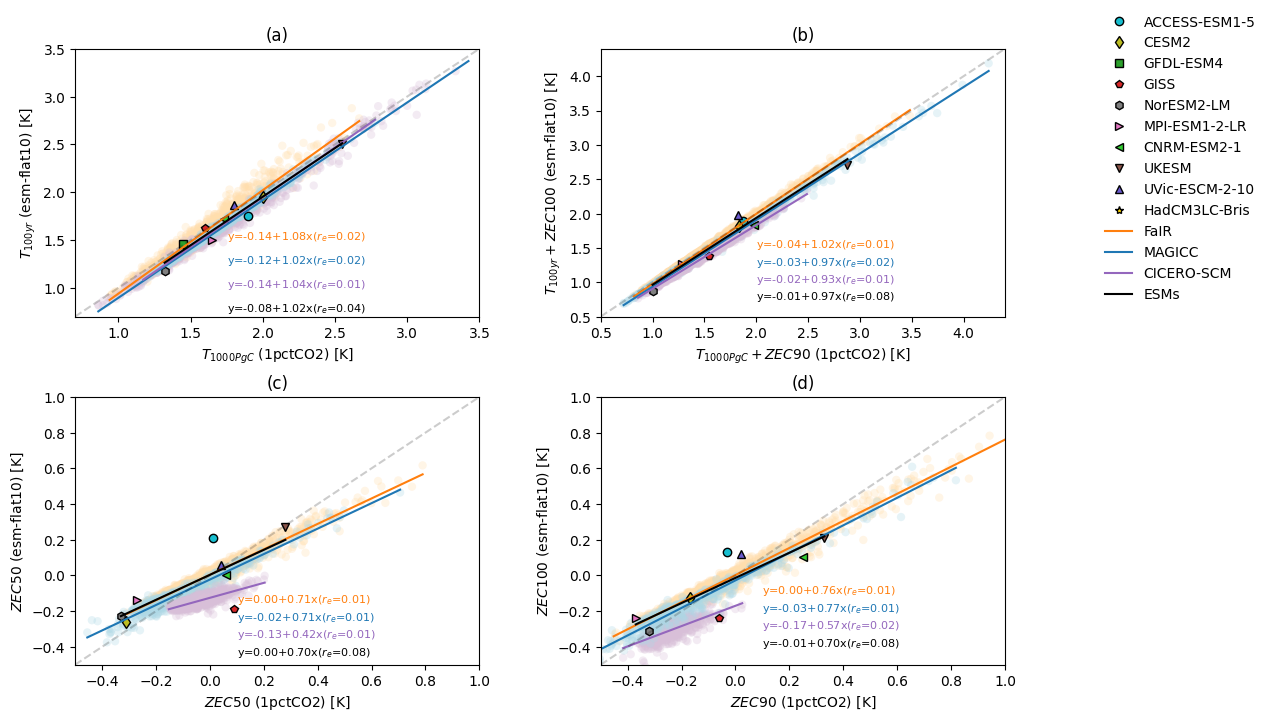

In [41]:
shp=['o','d','s','p','h','>','<','v','^','*']

fig = plt.figure(figsize=[12,8])

### subplot 1
sub = fig.add_subplot(2,2,1)
sub.scatter(fair_metrics_1pct['tcre'],tcre100f, color='navajowhite', alpha=0.3, edgecolor="none")
sub.scatter(magicc_metrics_1pct['tcre_1pctco2'],tcre100m, color='thistle',alpha=0.3, edgecolor="none")
sub.scatter(cicero_metrics_1pct['tcre'],tcre100c, color='lightblue',alpha=0.3, edgecolor="none")
#sub.scatter(df_zec_1pct['TCRE'],esm_tcre_flat10, color="black", edgecolor="none")
for i in range(len(mdls)):
    sub.plot(df_zec_1pct['TCRE'].iloc[i],esm_metrics_flat10.loc[mdls[i],'tcre'],shp[i],markerfacecolor=mcols[i],markeredgecolor='k',markersize=6,label=mdls[i])
# FaIR best fit
x = np.array(fair_metrics_1pct['tcre'])
y = np.array(tcre100f)
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="tab:orange")
sub.text(1.75,1.5,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:orange',fontsize=8)

#MAGICC best fit
x = np.array(magicc_metrics_1pct['tcre_1pctco2'])
y = np.array(tcre100m)
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='tab:blue')
sub.text(1.75,1.25,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:blue',fontsize=8)

#CICERO best fit
x = np.array(cicero_metrics_1pct['tcre'])
y = np.array(tcre100c)
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.plot(np.unique(x[idx]), np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])), color='tab:purple')
sub.text(1.75,1.,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:purple',fontsize=8)

# ESM best fit
x = np.array(df_zec_1pct['TCRE'])[np.isfinite(np.array(df_zec_1pct['TCRE']))]
y = np.array(esm_tcre_flat10)[np.isfinite(np.array(df_zec_1pct['TCRE']))]
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))
sub.text(1.75,0.75,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='black',fontsize=8)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="black")

sub.plot([0.7,3.5],[.7,3.5],'k--',alpha=0.2)
sub.set_xlim(0.7,3.5)
sub.set_ylim(0.7,3.5)
sub.set_ylabel('$T_{100yr}$ (esm-flat10) [K]')
sub.set_xlabel('$T_{1000PgC}$ (1pctCO2) [K]')
sub.scatter(-99,-99, color='navajowhite', alpha=1, edgecolor="none", label="FaIR")
sub.scatter(-99,-99, color='lightblue', alpha=1, edgecolor="none", label="MAGICC")
sub.scatter(-99,-99, color='thistle', alpha=1, edgecolor="none", label="CICERO-SCM")
sub.scatter(-99,-99, color="black", edgecolor="none", label="ESMs")
sub.set_title('(a)')
#sub.annotate('a) $T_{1000PgC}$', xy=(0.025, 0.92), xycoords='axes fraction', fontsize=12, ha='left', va='center')

### subplot 2
sub = fig.add_subplot(2,2,2)
sub.scatter(fair_metrics_1pct['zec100']+fair_metrics_1pct['tcre'],ds_fair.zec100+ds_fair.tcre, alpha=0.3,color='navajowhite', edgecolor="none")
sub.scatter(magicc_metrics_1pct['zec100_esm-1pct-brch-1000pgc']+magicc_metrics_1pct['tcre_1pctco2'],zec100m+tcre100m, color='lightblue',alpha=0.3, edgecolor="none")
sub.scatter(cicero_metrics_1pct['zec100']+cicero_metrics_1pct['tcre'],zec100c+tcre100c, color='thistle',alpha=0.3, edgecolor="none")
#sub.scatter(df_zec_1pct['ZEC100']+df_zec_1pct['TCRE'],esm_zec100_flat10+esm_tcre_flat10, color="black", edgecolor="none")
for i in range(len(mdls)):
    sub.plot((df_zec_1pct['ZEC100']+df_zec_1pct['TCRE']).iloc[i],(esm_zec100_flat10+esm_tcre_flat10)[i],shp[i],markerfacecolor=mcols[i],markeredgecolor='k',markersize=6,label=mdls[i])
# FaIR best fit
x = np.array(fair_metrics_1pct['zec100']+fair_metrics_1pct['tcre'])
y = np.array(ds_fair.zec100+ds_fair.tcre)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="tab:orange", label="FaIR")
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(2.,1.5,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:orange',fontsize=8)

#MAGICC best fit
x = np.array(magicc_metrics_1pct['zec100_esm-1pct-brch-1000pgc']+magicc_metrics_1pct['tcre_1pctco2'])
y = np.array(zec100m+tcre100m)
sub.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='tab:blue',label="MAGICC")
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(2.,1.25,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:blue',fontsize=8)

#CICERO best fit
x = np.array(cicero_metrics_1pct['zec100']+cicero_metrics_1pct['tcre'])
y = np.array(zec100c+tcre100c)
idx = np.isfinite(x) & np.isfinite(y)
sub.plot(np.unique(x[idx]), np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])), color='tab:purple',label="CICERO-SCM")
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(2.,1.,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:purple',fontsize=8)

# ESM best fit
x = np.array(df_zec_1pct['ZEC100']+df_zec_1pct['TCRE'])[np.isfinite(np.array(df_zec_1pct['ZEC100']+df_zec_1pct['TCRE']))]
y = np.array(esm_zec100_flat10+esm_tcre_flat10)[np.isfinite(np.array(df_zec_1pct['ZEC100']+df_zec_1pct['TCRE']))]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="black",label="ESMs")

idx = np.isfinite(x) & np.isfinite(y)
rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(2.,.75,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='k',fontsize=8)

sub.plot([0.5,4.4],[0.5,4.4],'k--',alpha=0.2)
sub.set_xlim(0.5,4.4)
sub.set_ylim(0.5,4.4)
sub.set_ylabel('$T_{100yr}+ZEC100$ (esm-flat10) [K]')
sub.set_xlabel('$T_{1000PgC}+ZEC90$ (1pctCO2) [K]')
sub.legend(frameon=False, loc="lower right", prop={'size': 10},bbox_to_anchor=(1.65, 0.01))

sub.set_title('(b)')
### subplot 3
sub = fig.add_subplot(2,2,3)
sub.scatter(fair_metrics_1pct['zec50'],ds_fair.zec50 ,alpha=0.3, color='navajowhite', edgecolor="none")
sub.scatter(magicc_metrics_1pct['zec50_esm-1pct-brch-1000pgc'],zec50m, color='lightblue', alpha=0.3, edgecolor="none")
sub.scatter(cicero_metrics_1pct['zec50'],zec50c, color='thistle', alpha=0.3, edgecolor="none")
#sub.scatter(df_zec_1pct['ZEC50'],esm_zec50_flat10, color="black", edgecolor="none")
for i in range(len(mdls)):
    sub.plot((df_zec_1pct['ZEC50']).iloc[i],(esm_zec50_flat10)[i],shp[i],markerfacecolor=mcols[i],markeredgecolor='k',markersize=6,label=mdls[i])

# FaIR best fit
x = np.array(fair_metrics_1pct['zec50'])
y = np.array(ds_fair.zec50)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="tab:orange")
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(0.1,-0.15,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:orange',fontsize=8)

#MAGICC best fit
x = np.array(magicc_metrics_1pct['zec50_esm-1pct-brch-1000pgc'])
y = np.array(zec50m)
sub.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='tab:blue')
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(0.1,-0.25,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:blue',fontsize=8)

#CICERO best fit
x = np.array(cicero_metrics_1pct['zec50'])
y = np.array(zec50c)
idx = np.isfinite(x) & np.isfinite(y)
sub.plot(np.unique(x[idx]), np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])), color='tab:purple')
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(0.1,-0.35,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:purple',fontsize=8)


# ESM best fit
x = np.array(df_zec_1pct['ZEC50'])[np.isfinite(np.array(df_zec_1pct['ZEC50']))]
y = np.array(esm_zec50_flat10)[np.isfinite(np.array(df_zec_1pct['ZEC50']))]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="black")
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(0.1,-0.45,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='k',fontsize=8)

sub.plot([-.5,1],[-.5,1],'k--',alpha=0.2)
sub.set_xlim(-0.5,1)
sub.set_ylim(-0.5,1)
sub.set_ylabel('$ZEC50$ (esm-flat10) [K]')
sub.set_xlabel('$ZEC50$ (1pctCO2) [K]')
sub.set_title('(c)')
### subplot 4
sub = fig.add_subplot(2,2,4)
sub.scatter(fair_metrics_1pct['zec100'], ds_fair.zec100 ,alpha=0.3, color='navajowhite', edgecolor="none")
sub.scatter(cicero_metrics_1pct['zec100'], zec100c ,alpha=0.3, color='thistle', edgecolor="none")

sub.scatter(magicc_metrics_1pct['zec100_esm-1pct-brch-1000pgc'], zec100m, color='lightblue', alpha=0.3, edgecolor="none")
#sub.scatter(df_zec_1pct['ZEC100'],esm_zec100_flat10, color="black", edgecolor="none")
for i in range(len(mdls)):
    sub.plot((df_zec_1pct['ZEC100']).iloc[i],(esm_zec100_flat10)[i],shp[i],markerfacecolor=mcols[i],markeredgecolor='k',markersize=6,label=mdls[i])

# FaIR best fit
x = np.array(fair_metrics_1pct['zec100'])
y = np.array(ds_fair.zec100)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="tab:orange")
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(0.1,-0.1,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:orange',fontsize=8)

#MAGICC best fit
x = np.array(magicc_metrics_1pct['zec100_esm-1pct-brch-1000pgc'])
y = np.array(zec100m)
sub.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='tab:blue')
idx = np.isfinite(x) & np.isfinite(y)

rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(0.1,-0.2,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:blue',fontsize=8)

#CICERO best fit
x = np.array(cicero_metrics_1pct['zec100'])
y = np.array(zec100c)
idx = np.isfinite(x) & np.isfinite(y)
rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.plot(np.unique(x[idx]), np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])), color='tab:purple')
sub.text(0.1,-0.3,'y=' "{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms),color='tab:purple',fontsize=8)
# ESM best fit
x = np.array(df_zec_1pct['ZEC100'])[np.isfinite(np.array(df_zec_1pct['ZEC100']))]
y = np.array(esm_zec100_flat10)[np.isfinite(np.array(df_zec_1pct['ZEC100']))]
idx = np.isfinite(x) & np.isfinite(y)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="black")
rms=np.sqrt(np.mean((np.unique(y[idx])- np.poly1d(np.polyfit(x[idx], y[idx], 1))(np.unique(x[idx])))**2))

sub.text(0.1,-0.4,'y='+"{0:0.2f}".format(np.polyfit(x[idx], y[idx], 1)[1]) + "{0:+.2f}".format(np.polyfit(x[idx], y[idx], 1)[0]) + 'x'+"($r_e$={0:0.2f})".format(rms) ,color='k',fontsize=8)

sub.plot([-.5,1],[-.5,1],'k--',alpha=0.2)
sub.set_xlim(-0.5,1)
sub.set_ylim(-0.5,1)
sub.set_ylabel('$ZEC100$ (esm-flat10) [K]')
sub.set_xlabel('$ZEC90$ (1pctCO2) [K]')
sub.set_title('(d)')
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig("images/flat10_SCM_ESM_metric_correlations.pdf", bbox_inches='tight')
plt.savefig("images/flat10_SCM_ESM_metric_correlations.jpg", bbox_inches='tight')

In [42]:
#run plot_c4mip to recreate these csvs
tas_zecmip=pd.read_csv('zecmip_tas.csv',index_col=0)
ce_zecmip=pd.read_csv('zecmip_emis.csv',index_col=0)
mdls_zecmip=ce_zecmip.columns
yr1000=(ce_zecmip.cumsum()>960).idxmax()+2

ACCESS-ESM1-5
CESM2
GFDL-ESM4
GISS
NorESM2-LM
MPI-ESM1-2-LR
CNRM-ESM2-1
UKESM
UVic-ESCM-2-10
HadCM3LC-Bris


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2626497982.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].plot(tas_zecmip.index-yr1000[mz],tas_zecmip.iloc[:,mz],'-',color='k',alpha=0.2,label='esm-1pct-brch-1000PgC')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2626497982.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].plot(tas_zecmip[:(int(yr1000[mz])-1)].index-yr1000[mz],tas_zecmip.iloc[:int(yr1000[mz]),mz],'-',color='k',alpha=0.2,label='1pctCO2')
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2626497982.py:12: FutureWarning: The behavior

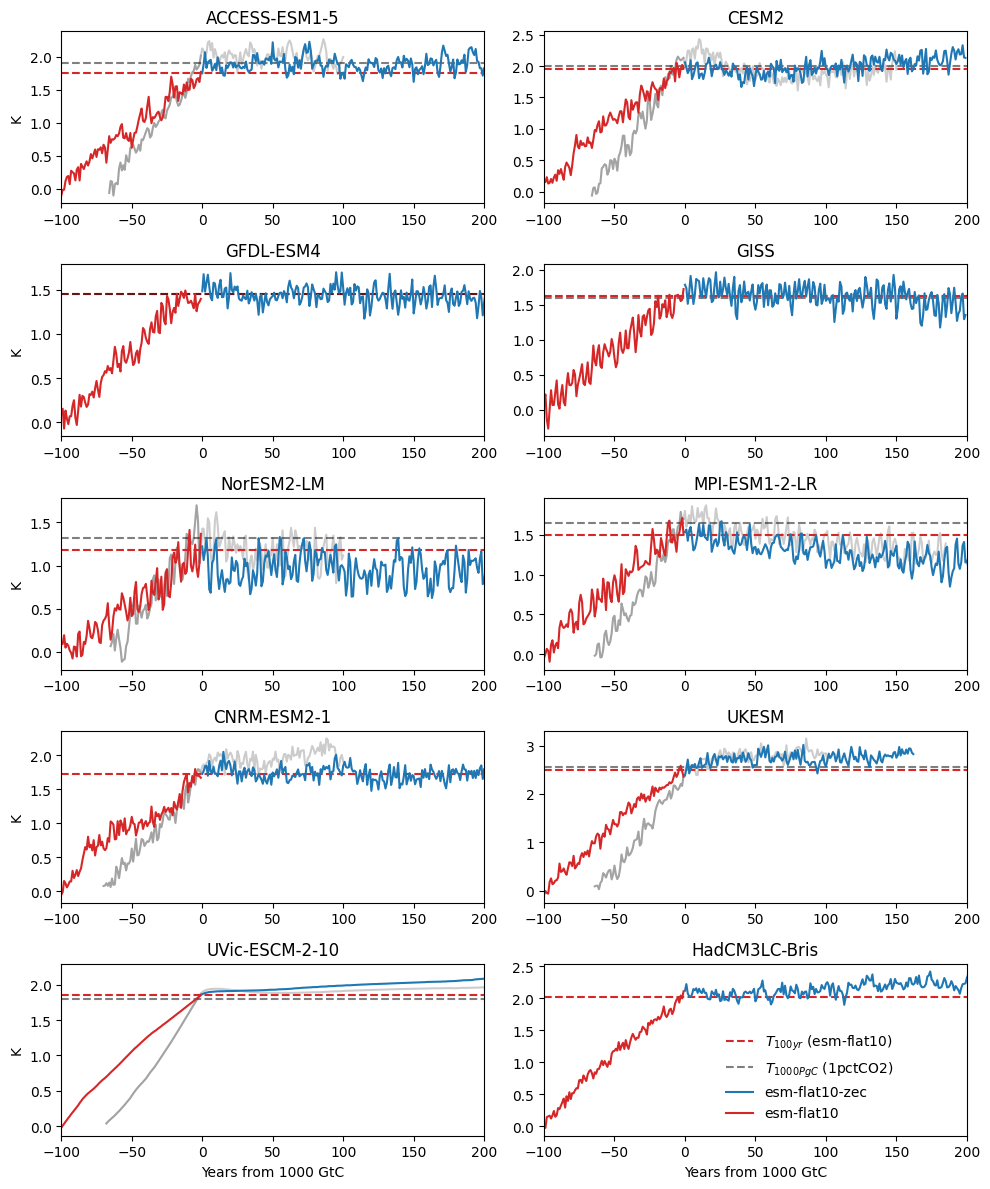

In [43]:
fig, axes = plt.subplots(5,2,figsize=(10, 12))
axes=axes.flatten()

for i,m in enumerate(mdls):
    print(m)
    try:
        mz=list(mdls_zecmip).index(m)
    except:
        mz=np.nan
    if ~np.isnan(mz)>0:
        axes[i].plot(tas_zecmip.index-yr1000[mz],tas_zecmip.iloc[:,mz],'-',color='k',alpha=0.2,label='esm-1pct-brch-1000PgC')
        axes[i].plot(tas_zecmip[:(int(yr1000[mz])-1)].index-yr1000[mz],tas_zecmip.iloc[:int(yr1000[mz]),mz],'-',color='k',alpha=0.2,label='1pctCO2')
    axes[i].axhline(esm_metrics_flat10.loc[m,'tcre'],color='tab:red',linestyle='--',label='$T_{100yr}$ (esm-flat10)')
    tmp=df_zec_1pct.loc[df_zec_1pct['Name'] == m]['TCRE']
    if len(tmp)>0:
      axes[i].axhline(tmp.iloc[0],color='k',linestyle='--',alpha=0.5, label='$T_{1000PgC}$ (1pctCO2)')
    

    cn0=ed[m]['flat10']['tas'][:20].mean()-(ed[m]['flat10']['tas'][10:30:1].mean()-ed[m]['flat10']['tas'][:20].mean())

    axes[i].plot(ed[m]['flat10-zec']['year'][100:]-ed[m]['flat10-zec']['year'][0]-100,ed[m]['flat10-zec']['tas'][100:]-cn0,'tab:blue',label='esm-flat10-zec')
    axes[i].plot(ed[m]['flat10-zec']['year'][:100]-ed[m]['flat10-zec']['year'][0]-100,ed[m]['flat10-zec']['tas'][0:100]-cn0,'tab:red',label='esm-flat10')
    axes[i].set_xlim(-100,200)
    axes[i].set_title(m)
    if i in [0,2,4,6,8]:
        axes[i].set_ylabel('K')
    if i in [8,9]:
        axes[i].set_xlabel('Years from 1000 GtC')
plt.tight_layout()
axes[9].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.4, 0.67))

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/1766764473.py:17: SyntaxWarning: invalid escape sequence '\D'
  sub.set_ylabel("$\Delta$ GMST [K]")


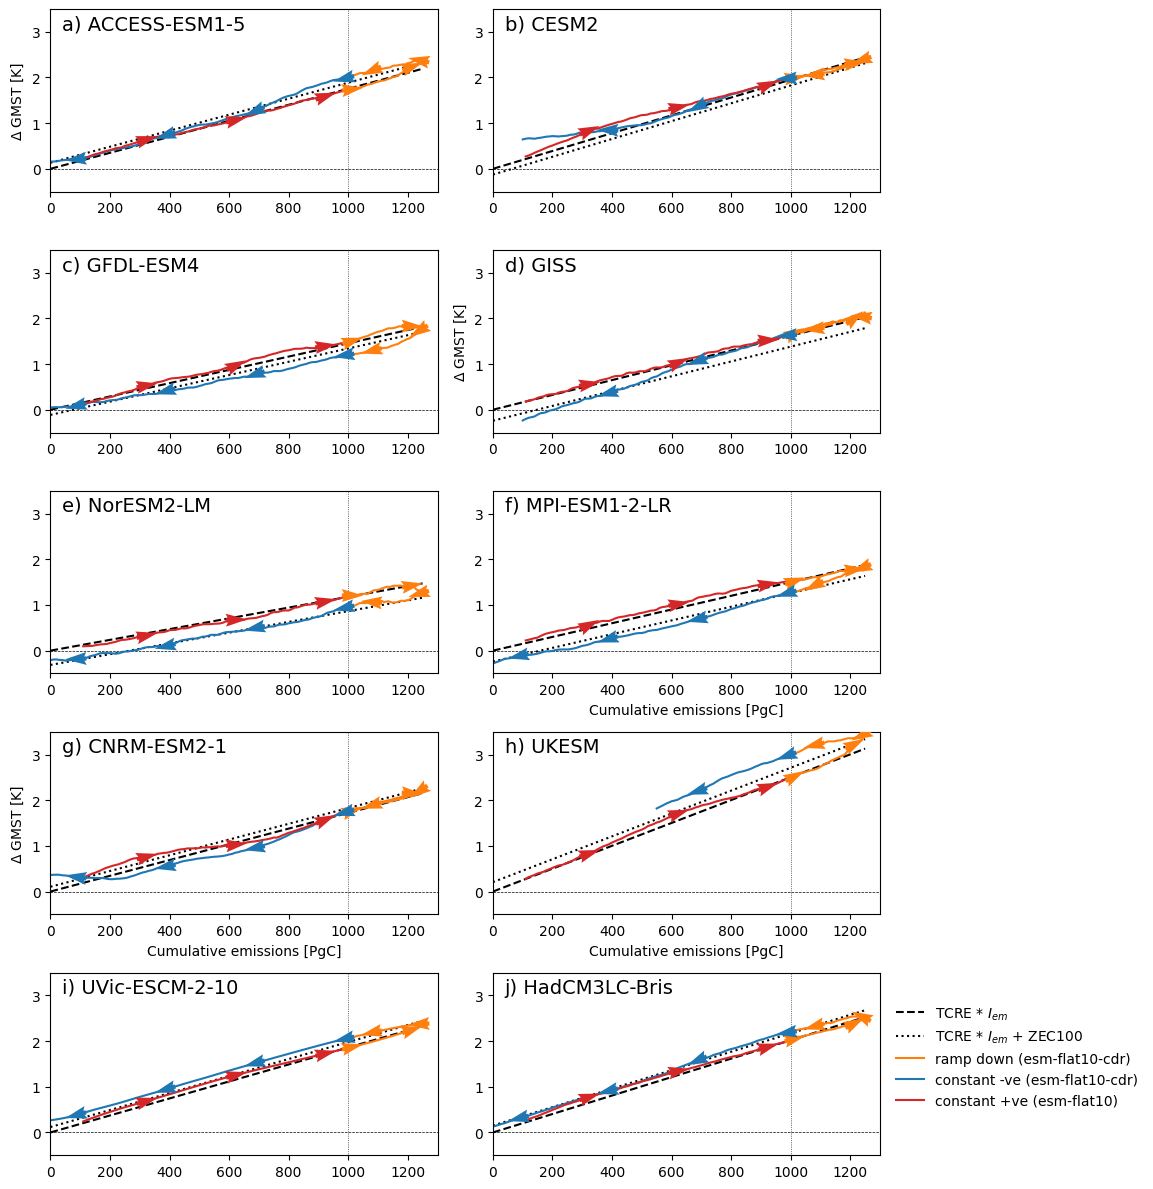

In [44]:
fls = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']

##window=21

fig = plt.figure(figsize=(9,12))

xxs = np.array((0.,1250))

for i,m in enumerate(mdls):
    sub = fig.add_subplot(5, 2, i+1)
    lncdr=np.min([len(ed[mdls[i]]['flat10-cdr']['co2'][1:][:]),300])

    #sub.set_title(mdls[i])
    if i in ( 5, 6,7):
        sub.set_xlabel("Cumulative emissions [PgC]")
    if i in (0, 3, 6):
        sub.set_ylabel("$\Delta$ GMST [K]")
    sub.set_ylim(-0.5,3.5)
    sub.set_xlim(0,1300)

    ## replace these lines with sloped ones
    #sub.axhline(esm_metrics_flat10.loc[m,'tcre'],color='k',linestyle='-',label='$T_{100yr}$ (esm-flat10)')
    #sub.axhline(esm_metrics_flat10.loc[m,'tcre']+esm_metrics_flat10.loc[m,'zec50'],color='k',linestyle='--',label='$T_{100yr}$+ZEC50  (esm-flat10-zec)')
    #sub.axhline(esm_metrics_flat10.loc[m,'tcre']+esm_metrics_flat10.loc[m,'zec100'],color='k',linestyle=':',label='$T_{100yr}$+ZEC100  (esm-flat10-zec)')
    
    sub.plot(xxs, xxs*esm_metrics_flat10.loc[m,'tcre']*1e-3,color='k',linestyle='--',label='TCRE * $I_{em}$')
    sub.plot(xxs, xxs*esm_metrics_flat10.loc[m,'tcre']*1e-3+esm_metrics_flat10.loc[m,'zec100'],color='k',linestyle=':',label='TCRE * $I_{em}$ + ZEC100')
    
    cn0=ed[m]['flat10']['tas'][:20].mean()-(ed[m]['flat10']['tas'][10:30:1].mean()-ed[m]['flat10']['tas'][:20].mean())

    x=np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[:lncdr]
    y=ed[mdls[i]]['flat10-cdr']['tas'].rolling(year=21,center=True).mean()[:lncdr]-cn0
    u = np.diff(x)
    v = np.diff(y)
    pos_x = x[:-1] + u/2
    pos_y = y[:-1] + v/2
    norm = np.sqrt(u**2+v**2) *2

   
    sub.plot(x[100:200], y[100:200], color="tab:orange", label='ramp down (esm-flat10-cdr)')
    sub.plot(x[200:lncdr], y[200:lncdr], color="tab:blue", label='constant -ve (esm-flat10-cdr)')
    sub.plot(x[0:100], y[0:100], color="tab:red", label='constant +ve (esm-flat10)')

    sub.quiver(pos_x[100:200:30], pos_y[100:200:30], u[100:200:30]/norm[100:200:30], v[100:200:30]/norm[100:200:30], angles="xy", zorder=5, pivot="mid",color='tab:orange', width=.02)
    
    sub.quiver(pos_x[200::30], pos_y[200::30], u[200::30]/norm[200::30], v[200::30]/norm[200::30], angles="xy", zorder=5, pivot="mid",color='tab:blue', width=.02)
    sub.quiver(pos_x[1:100:30], pos_y[1:100:30], u[1:100:30]/norm[1:100:30], v[1:100:30]/norm[1:100:30], angles="xy", zorder=5, pivot="mid",color='tab:red', width=.02)

  
    sub.axhline(0, color="black", lw=0.5, linestyle="--", zorder=0)
    sub.axvline(1000, color="black", lw=0.5, linestyle=":", zorder=0)
    
    sub.annotate(fls[i]+" "+mdls[i], xy=(0.03, 0.92), xycoords='axes fraction', fontsize=14, ha='left', va='center')

plt.tight_layout()
sub.legend(frameon=False, loc="upper left", prop={'size': 10}, bbox_to_anchor=(1.01, 0.89))

plt.savefig('images/temp_vs_cumulative_emissions_panel.png', dpi=300, bbox_inches='tight')

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2552863499.py:11: SyntaxWarning: invalid escape sequence '\D'
  sub.set_ylabel("$\Delta$ Atmospheric CO$_2$ [ppm]")
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2552863499.py:31: SyntaxWarning: invalid escape sequence '\D'
  sub.set_ylabel("$\Delta$ Land carbon sink [PgC]")
/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_1793/2552863499.py:46: SyntaxWarning: invalid escape sequence '\D'
  sub.set_ylabel("$\Delta$ Ocean carbon sink [PgC]")


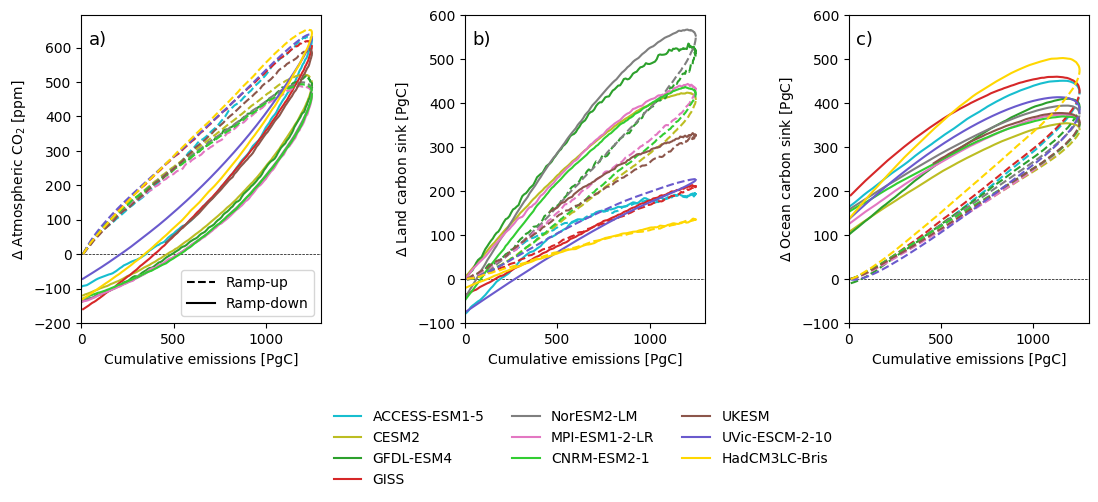

In [45]:
#colors=["tab:blue","tab:orange","tab:green","tab:red","tab:gray","tab:purple"]
window=21
time_ma = np.arange(int(window/2),len(ed[mdls[i]]['flat10-zec']['tas'])-int(window/2))

fig = plt.figure(figsize=(13,4))


sub = fig.add_subplot(1, 3, 1)
sub.set_xlim(0,1300)
#sub.set_xlabel("Cumulative emissions [PgC]")
sub.set_ylabel("$\Delta$ Atmospheric CO$_2$ [ppm]")
# ESMs
for i in np.arange(0,len(mdls)):
    lncdr=np.min([len(ed[mdls[i]]['flat10-cdr']['co2'][1:][:]),300])

    sub.plot(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[0:150], ed[mdls[i]]['flat10-cdr']['C_atm'][0:150], color=colors[i], linestyle="--")
    sub.plot(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[150:lncdr], ed[mdls[i]]['flat10-cdr']['C_atm'][150:lncdr], color=colors[i])
   # sub.scatter(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[149], ed[mdls[i]]['flat10-cdr']['C_atm'][149], color=colors[i], s=30, edgecolor="black", zorder=4)
sub.axhline(0, color="black", lw=0.5, linestyle="--", zorder=0)
sub.annotate('a)', xy=(0.03, 0.92), xycoords='axes fraction', fontsize=13, ha='left', va='center')
sub.set_xlabel("Cumulative emissions [PgC]")

sub.plot([-99,-99], color="black", linestyle='--', label="Ramp-up")
sub.plot([-99,-99], color="black", linestyle='-', label="Ramp-down")

sub.legend()
sub = fig.add_subplot(1, 3, 2)
sub.set_xlim(0,1300)
sub.set_ylim(-100,600)
sub.set_xlabel("Cumulative emissions [PgC]")
sub.set_ylabel("$\Delta$ Land carbon sink [PgC]")
# ESMs
for i in np.arange(0,len(mdls)):
    lncdr=np.min([len(ed[mdls[i]]['flat10-cdr']['co2'][1:][:]),300])

    sub.plot(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[0:150], np.cumsum(ed[mdls[i]]['flat10-cdr']['nbp'])[0:150], color=colors[i], linestyle="--")
    sub.plot(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[150:lncdr], np.cumsum(ed[mdls[i]]['flat10-cdr']['nbp'])[150:lncdr], color=colors[i])
   # sub.scatter(moving_average(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[0:300], window)[139], moving_average(np.cumsum(ed[mdls[i]]['flat10-cdr']['nbp'])[0:300], window)[139], color=colors[i], s=30, edgecolor="black", zorder=4)
sub.axhline(0, color="black", lw=0.5, linestyle="--", zorder=0)
sub.annotate('b)', xy=(0.03, 0.92), xycoords='axes fraction', fontsize=13, ha='left', va='center')

sub = fig.add_subplot(1, 3, 3)
sub.set_xlim(0,1300)
sub.set_ylim(-100,600)
sub.set_xlabel("Cumulative emissions [PgC]")
sub.set_ylabel("$\Delta$ Ocean carbon sink [PgC]")
# ESMs
for i in np.arange(0,len(mdls)):
    lncdr=np.min([len(ed[mdls[i]]['flat10-cdr']['co2'][1:][:]),300])

    sub.plot(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[0:150], np.cumsum(ed[mdls[i]]['flat10-cdr']['fgco2'])[0:150], color=colors[i], linestyle="--")
    sub.plot(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[150:lncdr], np.cumsum(ed[mdls[i]]['flat10-cdr']['fgco2'])[150:lncdr], color=colors[i], label=mdls[i])
    #sub.scatter(moving_average(np.cumsum(e_flat10_cdr['Emission Rate (PgC a-1)'])[0:lncdr], window)[139], moving_average(np.cumsum(ed[mdls[i]]['flat10-cdr']['fgco2'])[0:lncdr], window)[139], color=colors[i], s=30, edgecolor="black", zorder=4)
sub.legend(frameon=False, loc="upper left", prop={'size': 10}, bbox_to_anchor=(-2.2, -0.24), ncol=3)
sub.axhline(0, color="black", lw=0.5, linestyle="--", zorder=0)
sub.annotate('c)', xy=(0.03, 0.92), xycoords='axes fraction', fontsize=13, ha='left', va='center')
sub.set_xlabel("Cumulative emissions [PgC]")

fig.subplots_adjust(wspace=.6, hspace=1)
plt.savefig("images/flat10_ESM_results_hysteresis_panel.pdf", bbox_inches='tight')
plt.savefig("images/flat10_ESM_results_hysteresis_panel.jpg", bbox_inches='tight')
window=11

In [46]:
scm_metrics_flat10_cap=scm_metrics_flat10
esm_metrics_flat10_cap=esm_metrics_flat10

In [47]:
scol=scm_metrics_flat10.columns.map(str.upper)
scol=['tPW' if x == 'TPW' else x for x in scol]
ecol=esm_metrics_flat10.columns.map(str.upper)
ecol=['tPW' if x == 'TPW' else x for x in ecol]

In [48]:
scm_metrics_flat10_cap.columns=scol
esm_metrics_flat10_cap.columns=ecol

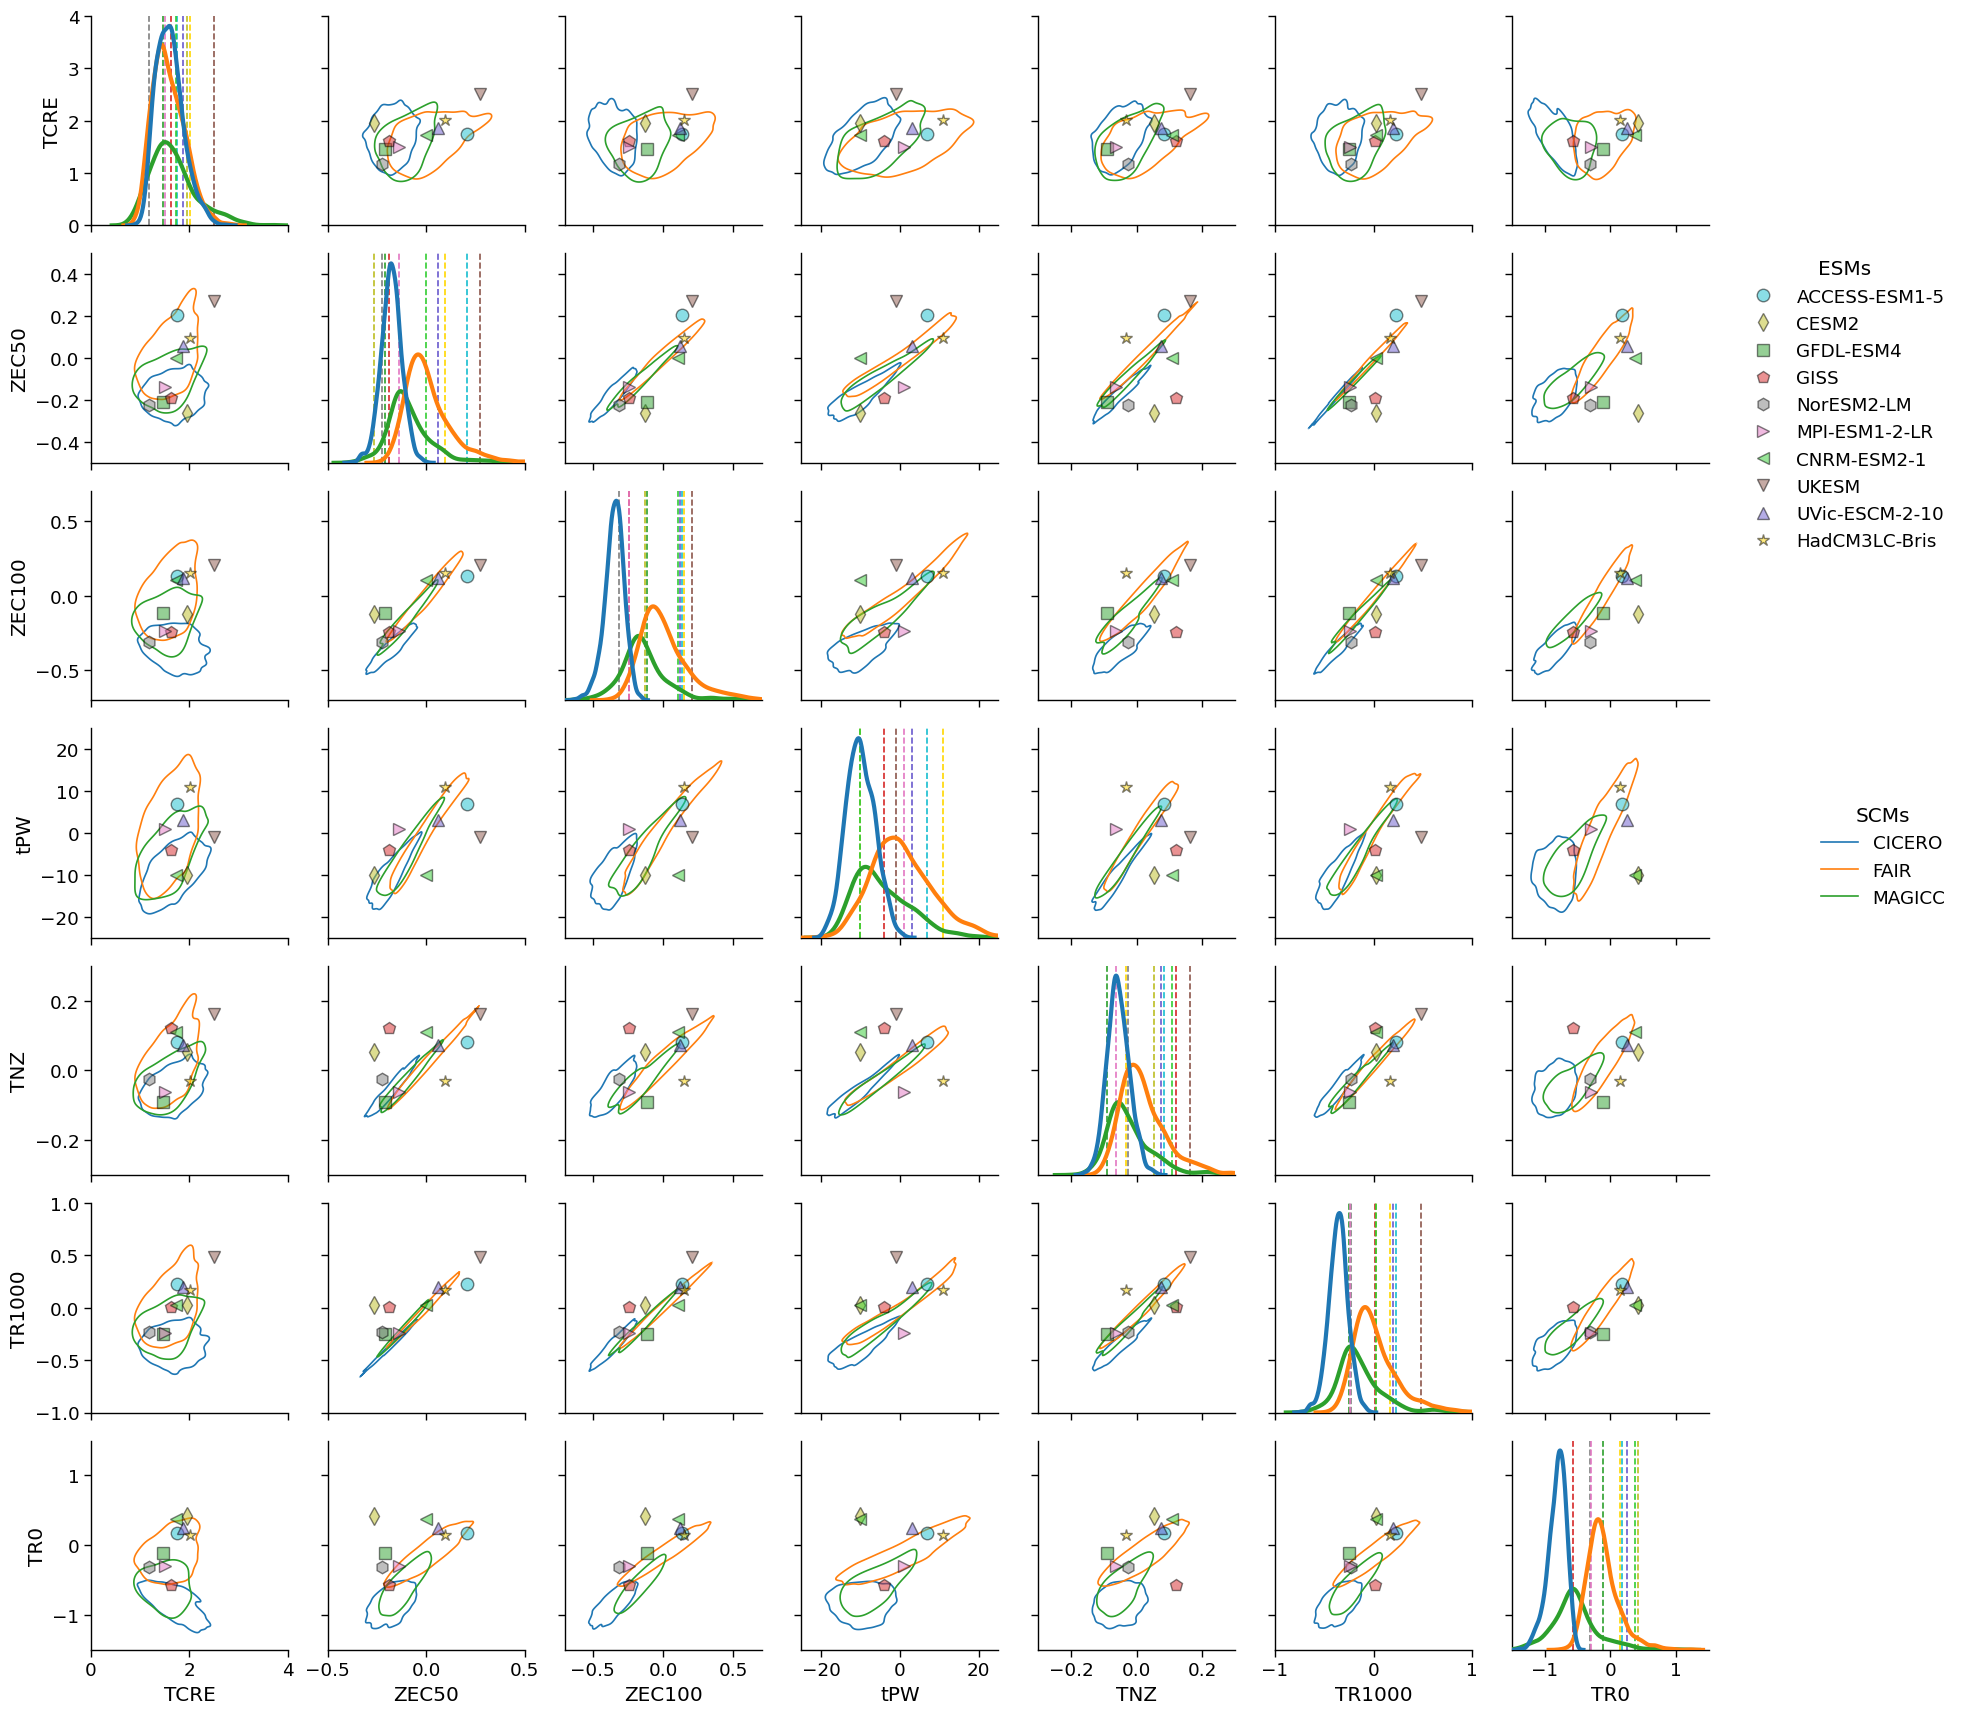

In [49]:
import seaborn as sns
mtrcs=scm_metrics_flat10_cap.columns[:-1].values
units=['K','K','K','years','K','K','K']
sns.set_context("paper", font_scale=1.5)
hue_kws={"cmap": ["Blues", "Greens", "Reds"]}
g = sns.PairGrid(scm_metrics_flat10_cap, hue="MODEL", diag_sharey=False)#, hue_kws={"cmap": ["Blues", "Greens", "Reds"]})
g = g.map_offdiag(sns.kdeplot, levels=[.1])

g = g.map_diag(sns.kdeplot, linewidth=3,common_norm=True)

rng=[[0,4],[-.5,.5],[-.7,.7],[-25,25],[-.3,.3],[-1,1],[-1.5,1.5]]
for i in range(7):
    for j in range(7):
        if i!=j:
            for k in range(len(mdls)):
                g.axes[i,j].plot(esm_metrics_flat10_cap.loc[mdls[k],mtrcs[j]],esm_metrics_flat10_cap.loc[mdls[k],mtrcs[i]],shp[k],markerfacecolor=mcols[k],markeredgecolor='k',markersize=9,label=mdls[k],alpha=0.5)
        if i==j:
            for k in range(len(mdls)):
                g.axes[i,j].axvline(esm_metrics_flat10_cap.loc[mdls[k],mtrcs[i]],color=mcols[k],linestyle='--')
            g.axes[i,j].set_ylim(rng[j])
        g.axes[i,j].set_xlim(rng[j])
g.axes[1,6].legend(bbox_to_anchor=(1.1, 1.05),title='ESMs', frameon=False)
g.add_legend(title='SCMs')
